In [1]:
from pathlib import Path
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
from tqdm.auto import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans
import utils
import sys
import os
import numpy as np
from environment import CONTEXTS_LABELS
from agent import neural_network
import seaborn as sns

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [3]:
save_path = Path("save")
save_path.exists()

True

In [4]:
data_dir = save_path / "first_successful_run"
data_dir_20 = save_path / "20runs1EW"
data_dir.exists()
data_dir_20.exists()

True

In [5]:
data_path = data_dir / "data.tar"
data_path_20 = data_dir_20 / "data.tar"
data_path.exists()
data_path_20.exists()

True

In [6]:
data_dict = torch.load(data_path, weights_only=False, map_location=DEVICE)
data_dict_20 = torch.load(data_path_20, weights_only=False, map_location=DEVICE)
#data_dict.keys()
data_dict_20.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [7]:
weights = data_dict_20["weights"]["val"]
len(weights) # between each layer


5

In [8]:
print(weights[0].shape) # there are 512 neurons, each connected to 19 inputs
print(weights[1].shape) # the hidden layers are 512x512
print(weights[4].shape) # the final layer has 3 neurons

torch.Size([512, 19])
torch.Size([512, 512])
torch.Size([3, 512])


In [9]:
weights[0][0] # each row is a neuron's weight vector
# each column is a projection of weights from the previous layer's neuron

tensor([-0.1998, -0.2099,  0.0237,  0.1754,  0.1490,  0.1077, -0.1085,  0.1156,
         0.1484,  0.1913, -0.0799, -0.1082, -0.1460,  0.1882,  0.0260, -0.1217,
        -0.2292, -0.1479, -0.2254], grad_fn=<SelectBackward0>)

## Model Architecture

In [10]:
'''
DQN(
      (mlp): Sequential(
        (Layer 0): Linear(in_features=19, out_features=512, bias=True)
        (Layer 1): Linear(in_features=512, out_features=512, bias=True)
        (): ReLU()
        (Layer 2): Linear(in_features=512, out_features=512, bias=True)
        (): ReLU()
        (Layer 3): Linear(in_features=512, out_features=512, bias=True)
        (): ReLU()
        (Layer 4): Linear(in_features=512, out_features=3, bias=True)
      )
    )
'''

'\nDQN(\n      (mlp): Sequential(\n        (Layer 0): Linear(in_features=19, out_features=512, bias=True)\n        (Layer 1): Linear(in_features=512, out_features=512, bias=True)\n        (): ReLU()\n        (Layer 2): Linear(in_features=512, out_features=512, bias=True)\n        (): ReLU()\n        (Layer 3): Linear(in_features=512, out_features=512, bias=True)\n        (): ReLU()\n        (Layer 4): Linear(in_features=512, out_features=3, bias=True)\n      )\n    )\n'

## Basic Statistics

In [11]:
# used for checking issues

for w_i, w_val in enumerate(weights):
    print(f"Layer {w_i}: mean={w_val.mean():.4f}, std={w_val.std():.4f}, max={w_val.max():.4f}, min={w_val.min():.4f}")

Layer 0: mean=-0.0023, std=0.1342, max=0.2541, min=-0.2524
Layer 1: mean=0.0000, std=0.0264, max=0.0991, min=-0.1079
Layer 2: mean=-0.0013, std=0.0263, max=0.0944, min=-0.1134
Layer 3: mean=-0.0009, std=0.0265, max=0.0913, min=-0.1014
Layer 4: mean=0.0029, std=0.0297, max=0.0711, min=-0.0754


## Weight Histograms

In [12]:
first_layer = weights[0]
second_layer = weights[1]
third_layer = weights[2]
fourth_layer = weights[3]
fifth_layer = weights[4]
print(first_layer.shape)
print(fifth_layer.shape)
first_layer[511]

torch.Size([512, 19])
torch.Size([3, 512])


tensor([-0.2156,  0.0187, -0.0898,  0.1267,  0.1934,  0.1992,  0.0227, -0.1447,
        -0.1592,  0.2109,  0.0100, -0.2239,  0.1154, -0.1566, -0.1918,  0.1054,
         0.1506,  0.0837,  0.1684], grad_fn=<SelectBackward0>)

In [13]:
# state is input : you can see format of input here

# conv_state = torch.cat(
#             (
#                 cue,
#                 north_cart_coords (x, y, cos head, sin head),
#                 south_cart_coords (x, y, cos head, sin head),
#                 north_polar_coords (length, cos alpha, sin alpha, cos head, sin head),
#                 south_polar_coords (length, cos alpha, sin alpha, cos head, sin head),
#             )
#         )

p = data_dict['p']
states = data_dict['all_states']
first_step = states[0][0][0]
second_step = states[0][0][1]
third_step = states[0][0][2]
print(first_step)
print(second_step)
print(third_step)

tensor([ 0.0000e+00,  0.0000e+00,  2.0000e+00, -1.0000e+00,  4.3711e-08,
         4.0000e+00,  2.0000e+00,  1.0000e+00, -4.3711e-08,  2.0000e+00,
        -4.3711e-08,  1.0000e+00, -4.3711e-08,  1.0000e+00,  4.4721e+00,
         8.9443e-01,  4.4721e-01,  8.9443e-01, -4.4721e-01])
tensor([ 0.0000e+00,  0.0000e+00,  2.0000e+00, -1.0000e+00,  4.3711e-08,
         4.0000e+00,  2.0000e+00,  1.0000e+00, -4.3711e-08,  2.0000e+00,
        -4.3711e-08,  1.0000e+00, -4.3711e-08,  1.0000e+00,  4.4721e+00,
         8.9443e-01,  4.4721e-01,  8.9443e-01, -4.4721e-01])
tensor([ 0.0000e+00,  0.0000e+00,  1.0000e+00, -0.0000e+00, -1.0000e+00,
         4.0000e+00,  3.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,
        -4.3711e-08,  1.0000e+00, -1.0000e+00,  8.7423e-08,  5.0000e+00,
         8.0000e-01,  6.0000e-01,  6.0000e-01,  8.0000e-01])


## Odor Input Analysis

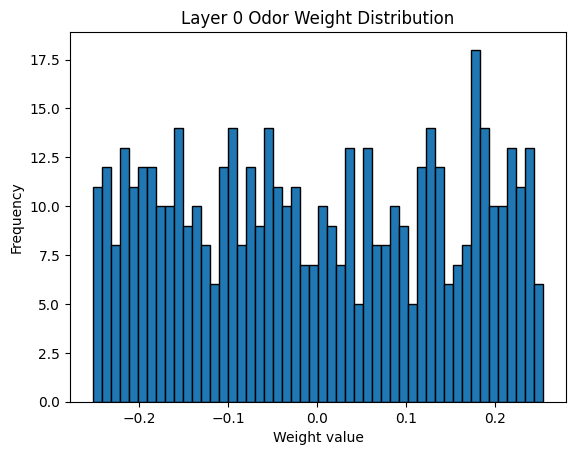

512.0


In [14]:
counts, bin_edges, patches = plt.hist(first_layer.detach().numpy()[:,0], bins=50, edgecolor='black')
plt.title("Layer 0 Odor Weight Distribution")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()
print(sum(counts))

[-0.1998128   0.17513919 -0.1319925  -0.20062828  0.04089496  0.1870508
 -0.06472185 -0.07028652 -0.24465942  0.07526223  0.23649448  0.14803325
 -0.07977153 -0.2169707  -0.03071824 -0.07706574 -0.23943804  0.1151267
 -0.02949236 -0.16083886 -0.03418399 -0.04710616 -0.07352282 -0.17363931
  0.22110371  0.14614941  0.05583746 -0.22374326  0.06032417 -0.03635943
  0.1339636   0.232964   -0.18660906 -0.04920603 -0.05940389 -0.03809941
  0.13876133 -0.12413648  0.19348642 -0.07313628  0.12456421 -0.21541229
  0.06514941  0.06639923  0.05297076  0.11421     0.12291023 -0.16504122
  0.2251743  -0.09457178 -0.10874945  0.05760404 -0.00341082 -0.09672322
  0.01760331  0.24634385  0.25410494  0.21314354 -0.05105926 -0.10948739
  0.0844263  -0.12623292  0.23417658  0.04016981  0.24320842 -0.20623128
 -0.24842675 -0.01221814  0.00144019  0.13989258 -0.0990973  -0.20042777
 -0.05015827  0.01071089 -0.08387938 -0.16326204 -0.18277453 -0.03062764
 -0.0584424   0.17662302 -0.21383838  0.11829601  0.0

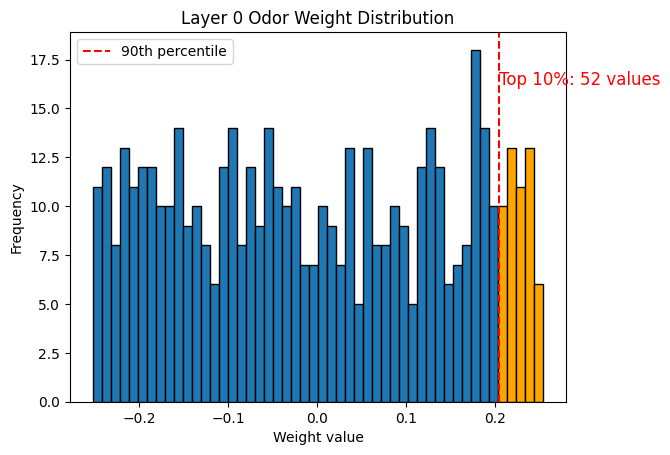

In [15]:
W = first_layer.detach().numpy()[:,0]

print(W)
print(len(W))

# Compute 90th percentile threshold
threshold = np.percentile(W, 90)

# Plot histogram
counts, bin_edges, patches = plt.hist(W, bins=50, edgecolor='black')

# Count how many weights are in the top 10%
top_10_count = np.sum(W > threshold)

# Highlight bins that start above the 90th percentile
for i in range(len(patches)):
    bin_left = bin_edges[i]
    bin_right = bin_edges[i+1]
    
    # If the bin overlaps with the top 10% range
    if bin_right > threshold:
        patches[i].set_facecolor('orange')  # Highlight color

# Add plot labels
plt.title("Layer 0 Odor Weight Distribution")
plt.xlabel("Weight value")
plt.ylabel("Frequency")

# Optional: Add a vertical line at the threshold
plt.axvline(threshold, color='red', linestyle='--', label='90th percentile')
plt.legend()

# Add annotation for number of values in top 10%
plt.text(
    threshold,                # x-position (at threshold)
    max(counts) * 0.9,        # y-position (near top of plot)
    f"Top 10%: {top_10_count} values",
    color='red',
    fontsize=12,
    ha='left'
)

plt.show()

In [16]:
top_10_percent = W[W > threshold]
print(top_10_percent)
max_weight = max(top_10_percent)
print(max_weight)
index = np.where(W == max_weight)[0][0]
print(index)

max_threshold = 0.25
indices = np.where(W > max_threshold)[0]
print(indices)  

[0.23649448 0.22110371 0.232964   0.2251743  0.24634385 0.25410494
 0.21314354 0.23417658 0.24320842 0.23858191 0.22821176 0.2439634
 0.20494364 0.21920352 0.2495712  0.21356456 0.25248215 0.2328365
 0.21587555 0.24349801 0.25315058 0.21825635 0.22589082 0.21972476
 0.24287285 0.22806397 0.2200719  0.21208307 0.21719629 0.23487657
 0.23525596 0.22196665 0.2247195  0.23432484 0.21934569 0.24158326
 0.20620455 0.23503855 0.20758136 0.20901963 0.20431411 0.20678964
 0.23309208 0.22171536 0.23888223 0.21531434 0.21999033 0.23122144
 0.2257015  0.24775052 0.23383497 0.21531989]
0.25410494
56
[ 56 147 180]


In [89]:
second_layer = weights[1]
print(first_layer.shape)
second_layer.shape

# so you want column of node 56

torch.Size([512, 19])


torch.Size([512, 512])

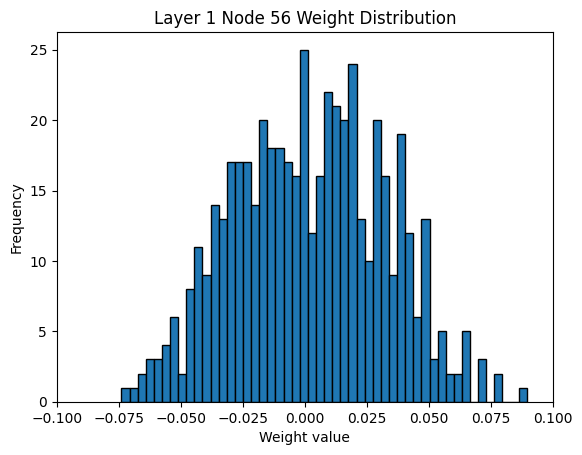

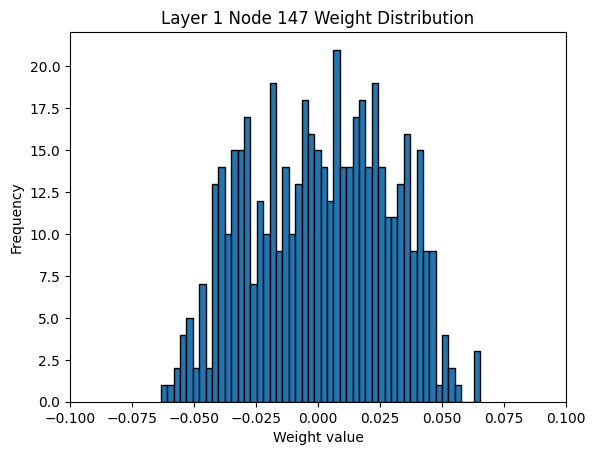

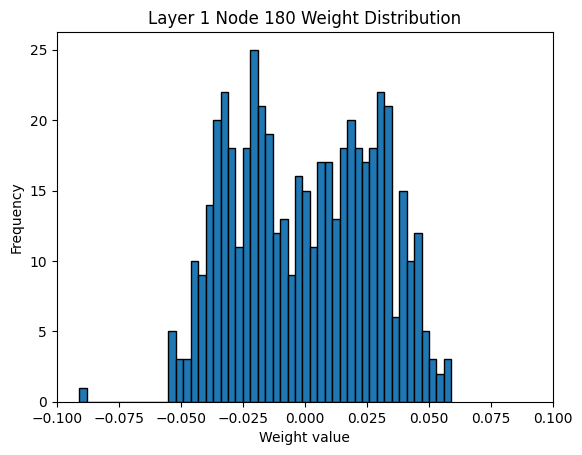

In [94]:
for col in [56, 147, 180]:

    W = second_layer.detach().numpy()[:,col]

    # print(W)
    # print(len(W))

    # Compute 90th percentile threshold
    threshold = np.percentile(W, 90)

    # Plot histogram
    counts, bin_edges, patches = plt.hist(W, bins=50, edgecolor='black')

    # Count how many weights are in the top 10%
    top_10_count = np.sum(W > threshold)

    # # Highlight bins that start above the 90th percentile
    # for i in range(len(patches)):
    #     bin_left = bin_edges[i]
    #     bin_right = bin_edges[i+1]
        
    #     # If the bin overlaps with the top 10% range
    #     if bin_right > threshold:
    #         patches[i].set_facecolor('orange')  # Highlight color

    # Add plot labels
    plt.title(f"Layer 1 Node {col} Weight Distribution")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.xlim(-0.1,0.1)
    plt.savefig(f"figures/layer1node{col}_hist.png", dpi=500)

    # # Optional: Add a vertical line at the threshold
    # plt.axvline(threshold, color='red', linestyle='--', label='90th percentile')
    # plt.legend()
    # plt.xlim(-0.1, 0.1)

    plt.show()

In [19]:
for col in [56, 147, 180]:
    W = second_layer.detach().numpy()[:,col]

    # Compute 90th percentile threshold
    threshold = np.percentile(W, 90)

    top_10_percent = W[W > threshold]
    #print(top_10_percent)
    mean = np.mean(top_10_percent)
    max_val = max(top_10_percent)
    min_val = min(top_10_percent)
    std = np.std(top_10_percent)
    print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

Mean: 0.05357
Std: 0.01109
Max: 0.08948
Min: 0.04144



Mean: 0.04513
Std: 0.00661
Max: 0.06549
Min: 0.03751



Mean: 0.04431
Std: 0.00556
Max: 0.05905
Min: 0.03654





In [20]:
for col in [56, 147, 180]:
    W = second_layer.detach().numpy()[:,col]
    

    # Compute 90th percentile threshold
    threshold = np.percentile(W, 90)

    top_10_percent = W[W > threshold]
    print(top_10_percent)
    max_threshold = 0.075
    indices = np.where(W > max_threshold)[0]
    print(indices)  
    # mean = np.mean(top_10_percent)
    # max_val = max(top_10_percent)
    # min_val = min(top_10_percent)
    # std = np.std(top_10_percent)
    # print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

[0.04992979 0.04848761 0.06528857 0.04287833 0.04892505 0.06404202
 0.05483739 0.05021501 0.0478795  0.04751932 0.0508967  0.05651817
 0.04842446 0.05788069 0.04991941 0.05587248 0.07659746 0.0442492
 0.0457046  0.05491794 0.08947595 0.04746921 0.06266961 0.04201533
 0.07932281 0.06245638 0.04251066 0.04164996 0.06622011 0.04786017
 0.05802391 0.04734825 0.04144387 0.04171386 0.0441478  0.05320086
 0.05542623 0.04213063 0.04164964 0.05044353 0.06580017 0.0493953
 0.04650225 0.04541951 0.04231082 0.06502202 0.0460364  0.07247987
 0.06997014 0.0716726  0.04365249 0.0491145 ]
[180 203 220]
[0.04152659 0.04213378 0.04403586 0.0518809  0.04070662 0.04033845
 0.04675334 0.04217739 0.04296632 0.04028878 0.03878305 0.03800897
 0.05078283 0.04039568 0.05457502 0.04574983 0.06414508 0.04133221
 0.04733598 0.04554914 0.03915934 0.04336558 0.05509368 0.03895299
 0.04111699 0.04520342 0.04706219 0.05160948 0.04968734 0.04651029
 0.04062201 0.03878443 0.04204063 0.04128705 0.0503896  0.05627243
 0.0

In [21]:
W = second_layer.detach().numpy()[:,56]
# Compute 90th percentile threshold
threshold = np.percentile(W, 90)
top_10_percent = W[W > threshold]
print(top_10_percent)
max_weight = max(top_10_percent)
print(max_weight)
index = np.where(W == max_weight)[0][0]
print(index)

max_threshold = 0.075
indices = np.where(W > max_threshold)[0]
print(indices)  

[0.04992979 0.04848761 0.06528857 0.04287833 0.04892505 0.06404202
 0.05483739 0.05021501 0.0478795  0.04751932 0.0508967  0.05651817
 0.04842446 0.05788069 0.04991941 0.05587248 0.07659746 0.0442492
 0.0457046  0.05491794 0.08947595 0.04746921 0.06266961 0.04201533
 0.07932281 0.06245638 0.04251066 0.04164996 0.06622011 0.04786017
 0.05802391 0.04734825 0.04144387 0.04171386 0.0441478  0.05320086
 0.05542623 0.04213063 0.04164964 0.05044353 0.06580017 0.0493953
 0.04650225 0.04541951 0.04231082 0.06502202 0.0460364  0.07247987
 0.06997014 0.0716726  0.04365249 0.0491145 ]
0.08947595
203
[180 203 220]


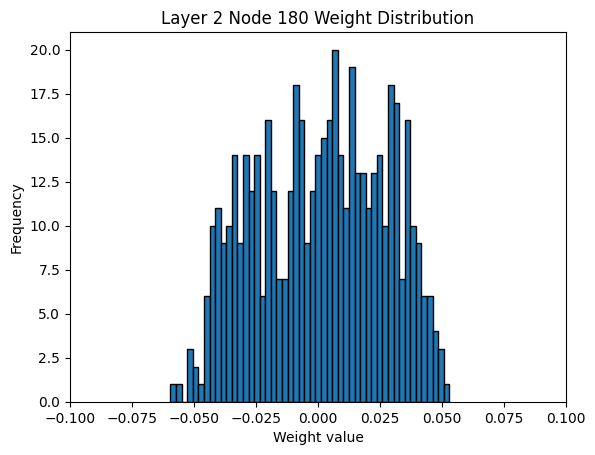

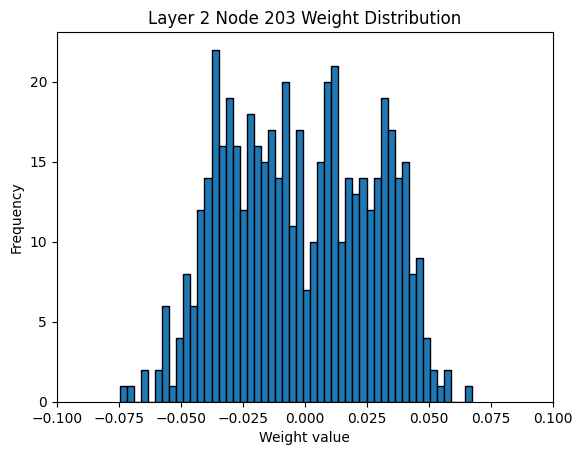

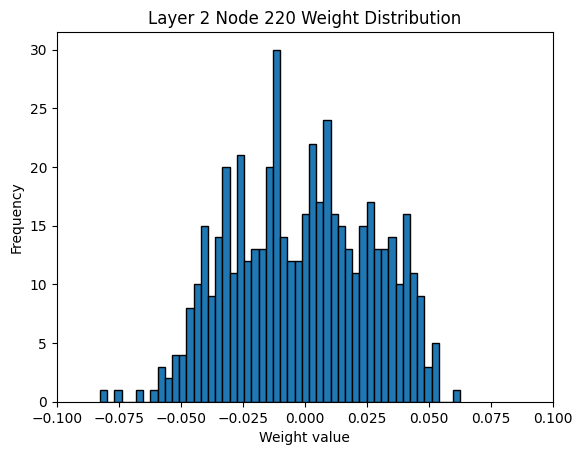

In [93]:
third_layer = weights[2]
for col in [180, 203, 220]:

    W = third_layer.detach().numpy()[:,col]

    # print(W)
    # print(len(W))

    # Compute 90th percentile threshold
    threshold = np.percentile(W, 90)

    # Plot histogram
    counts, bin_edges, patches = plt.hist(W, bins=50, edgecolor='black')

    # Count how many weights are in the top 10%
    top_10_count = np.sum(W > threshold)

    # # Highlight bins that start above the 90th percentile
    # for i in range(len(patches)):
    #     bin_left = bin_edges[i]
    #     bin_right = bin_edges[i+1]
        
    #     # If the bin overlaps with the top 10% range
    #     if bin_right > threshold:
    #         patches[i].set_facecolor('orange')  # Highlight color

    # Add plot labels
    plt.title(f"Layer 2 Node {col} Weight Distribution")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.xlim(-0.1,0.1)
    plt.savefig(f"figures/layer2node{col}_hist.png", dpi=500)

    # # Optional: Add a vertical line at the threshold
    # plt.axvline(threshold, color='red', linestyle='--', label='90th percentile')
    # plt.legend()
    # #plt.xlim(-0.1, 0.1)

    plt.show()

In [23]:
for col in [180, 203, 220]:
    W = third_layer.detach().numpy()[:,col]

    # Compute 90th percentile threshold
    threshold = np.percentile(W, 90)

    top_10_percent = W[W > threshold]
    #print(top_10_percent)
    mean = np.mean(top_10_percent)
    max_val = max(top_10_percent)
    min_val = min(top_10_percent)
    std = np.std(top_10_percent)
    print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

Mean: 0.04120
Std: 0.00443
Max: 0.05297
Min: 0.03569



Mean: 0.04392
Std: 0.00613
Max: 0.06746
Min: 0.03697



Mean: 0.04422
Std: 0.00502
Max: 0.06272
Min: 0.03808





In [24]:
for col in [180, 203, 220]:
    W = third_layer.detach().numpy()[:,col]

    # Compute 90th percentile threshold
    threshold = np.percentile(W, 90)

    top_10_percent = W[W > threshold]
    print(top_10_percent)
    max_threshold = 0.06
    indices = np.where(W > max_threshold)[0]
    print(indices) 
    # mean = np.mean(top_10_percent)
    # max_val = max(top_10_percent)
    # min_val = min(top_10_percent)
    # std = np.std(top_10_percent)
    # print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

[0.04172547 0.04569391 0.04922438 0.03569312 0.03596831 0.03886189
 0.04109947 0.04709676 0.03769568 0.03571802 0.04977375 0.0389728
 0.04765851 0.04150707 0.04022096 0.04255116 0.03975581 0.03698523
 0.03571449 0.03723762 0.03909398 0.03705733 0.03821389 0.03713208
 0.03616976 0.03704293 0.04612174 0.04711362 0.03622175 0.04805967
 0.04069005 0.04597778 0.03574913 0.0368338  0.0440689  0.03614308
 0.03724764 0.04114382 0.04551917 0.05296724 0.04311801 0.0388574
 0.04972627 0.03906279 0.04478896 0.03939958 0.04230059 0.04173771
 0.04166495 0.04155292 0.04188988 0.04039326]
[]
[0.03904987 0.03697313 0.0395779  0.04223396 0.05258787 0.04214492
 0.03837397 0.03959708 0.04968109 0.04066952 0.03864922 0.03990187
 0.03910698 0.04179454 0.04969731 0.04108555 0.04778986 0.04135612
 0.04270215 0.06745771 0.03875644 0.04640837 0.03866637 0.04673521
 0.0394131  0.03729978 0.04712891 0.04541925 0.05717767 0.05476691
 0.03716384 0.04472966 0.03998926 0.04156213 0.04919798 0.03960657
 0.04243707 0.0

In [25]:
W = third_layer.detach().numpy()[:,203]
# Compute 90th percentile threshold
threshold = np.percentile(W, 90)
top_10_percent = W[W > threshold]
print(top_10_percent)
max_weight = max(top_10_percent)
print(max_weight)
index = np.where(W == max_weight)[0][0]
print(index)

max_threshold = 0.06
indices = np.where(W > max_threshold)[0]
print(indices)  

[0.03904987 0.03697313 0.0395779  0.04223396 0.05258787 0.04214492
 0.03837397 0.03959708 0.04968109 0.04066952 0.03864922 0.03990187
 0.03910698 0.04179454 0.04969731 0.04108555 0.04778986 0.04135612
 0.04270215 0.06745771 0.03875644 0.04640837 0.03866637 0.04673521
 0.0394131  0.03729978 0.04712891 0.04541925 0.05717767 0.05476691
 0.03716384 0.04472966 0.03998926 0.04156213 0.04919798 0.03960657
 0.04243707 0.04351684 0.05178329 0.03798858 0.03878237 0.04244718
 0.04047053 0.04666796 0.04705706 0.044483   0.03945997 0.04682171
 0.05817119 0.04696284 0.03727742 0.04497452]
0.067457706
166
[166]


In [26]:
W = third_layer.detach().numpy()[:,220]
# Compute 90th percentile threshold
threshold = np.percentile(W, 90)
top_10_percent = W[W > threshold]
print(top_10_percent)
max_weight = max(top_10_percent)
print(max_weight)
index = np.where(W == max_weight)[0][0]
print(index)

max_threshold = 0.06
indices = np.where(W > max_threshold)[0]
print(indices)  

[0.03956601 0.05092559 0.04077415 0.05258808 0.04335112 0.04423514
 0.0388066  0.04237245 0.04436493 0.04553766 0.04759374 0.04425299
 0.04427327 0.04133648 0.0409674  0.06272095 0.04204574 0.0509022
 0.03841166 0.04741023 0.0430597  0.04989619 0.04262719 0.04684786
 0.04363078 0.04024845 0.05257324 0.04001439 0.04131556 0.04048541
 0.03959878 0.04803415 0.03960438 0.03882024 0.05349156 0.03937086
 0.04088215 0.03940437 0.04684303 0.04547617 0.04661845 0.05200566
 0.03975828 0.03808309 0.04549065 0.04164674 0.05217668 0.03864982
 0.04488845 0.03947702 0.04180035 0.04438009]
0.06272095
217
[217]


In [27]:
fourth_layer = weights[3]
fifth_layer = weights[4]
fifth_layer.shape

torch.Size([3, 512])

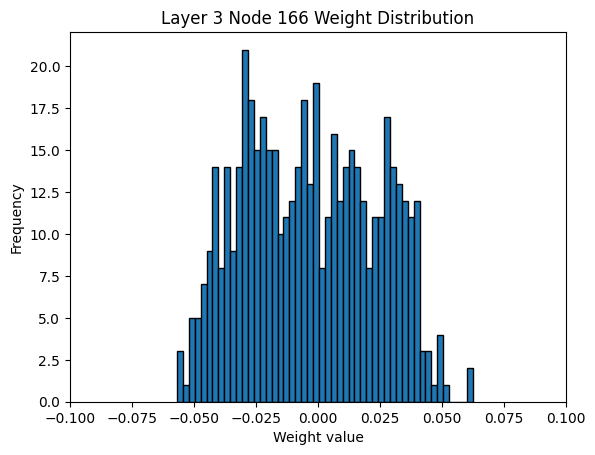

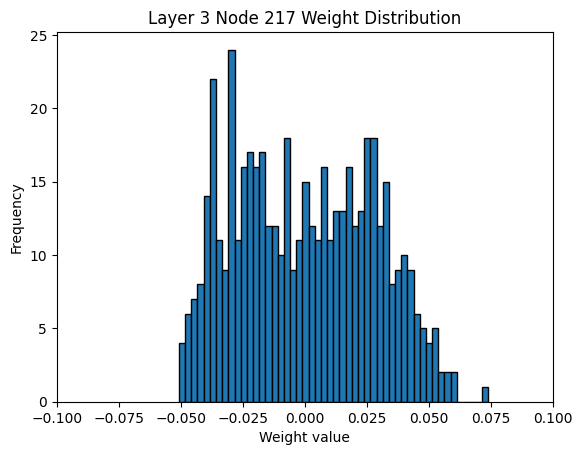

In [95]:
for col in [166, 217]:

    W = fourth_layer.detach().numpy()[:,col]

    # print(W)
    # print(len(W))

    # Compute 90th percentile threshold
    threshold = np.percentile(W, 90)

    # Plot histogram
    counts, bin_edges, patches = plt.hist(W, bins=50, edgecolor='black')

    # Count how many weights are in the top 10%
    top_10_count = np.sum(W > threshold)

    # # Highlight bins that start above the 90th percentile
    # for i in range(len(patches)):
    #     bin_left = bin_edges[i]
    #     bin_right = bin_edges[i+1]
        
    #     # If the bin overlaps with the top 10% range
    #     if bin_right > threshold:
    #         patches[i].set_facecolor('orange')  # Highlight color

    # Add plot labels
    plt.title(f"Layer 3 Node {col} Weight Distribution")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.xlim(-0.1,0.1)
    plt.savefig(f"figures/layer3node{col}_hist.png", dpi=500)

    # # Optional: Add a vertical line at the threshold
    # plt.axvline(threshold, color='red', linestyle='--', label='90th percentile')
    # plt.legend()
    # #plt.xlim(-0.1, 0.1)

    plt.show()

In [29]:
for col in [166, 217]:
    W = fourth_layer.detach().numpy()[:,col]

    # Compute 90th percentile threshold
    threshold = np.percentile(W, 90)

    top_10_percent = W[W > threshold]
    #print(top_10_percent)
    mean = np.mean(top_10_percent)
    max_val = max(top_10_percent)
    min_val = min(top_10_percent)
    std = np.std(top_10_percent)
    print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

Mean: 0.04019
Std: 0.00636
Max: 0.06240
Min: 0.03364



Mean: 0.04619
Std: 0.00702
Max: 0.07371
Min: 0.03778





In [30]:
for col in [166, 217]:
    W = fourth_layer.detach().numpy()[:,col]

    # Compute 90th percentile threshold
    threshold = np.percentile(W, 90)

    top_10_percent = W[W > threshold]
    print(top_10_percent)
    max_threshold = 0.07
    indices = np.where(W > max_threshold)[0]
    print(indices)  
    # mean = np.mean(top_10_percent)
    # max_val = max(top_10_percent)
    # min_val = min(top_10_percent)
    # std = np.std(top_10_percent)
    # print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

[0.06233906 0.04933199 0.03527454 0.05141813 0.04258965 0.03436835
 0.04333269 0.0336975  0.03431293 0.03853118 0.06239912 0.03917487
 0.0374359  0.04959802 0.03839402 0.04362289 0.0386499  0.03721184
 0.03710119 0.03374753 0.04055277 0.04012733 0.04392816 0.039753
 0.04225507 0.0393842  0.04013284 0.03502237 0.03747321 0.03436099
 0.03582606 0.04276671 0.03728839 0.04744513 0.03777871 0.03579591
 0.04825224 0.03948005 0.04048925 0.03388568 0.04996143 0.03446392
 0.03776233 0.03364449 0.03441846 0.03991607 0.03994064 0.04006961
 0.03795814 0.03567953 0.03508938 0.03633423]
[]
[0.05078033 0.06074222 0.04210528 0.04741797 0.0410334  0.05200605
 0.0406802  0.04437995 0.05903333 0.0440609  0.04222772 0.05244194
 0.04335804 0.05650597 0.04877922 0.05136136 0.03777658 0.0378175
 0.04566438 0.03831133 0.0382125  0.04065209 0.04793348 0.04018959
 0.04082278 0.04404143 0.05479109 0.05715438 0.05236634 0.04644594
 0.04742866 0.04114811 0.0423134  0.05415548 0.04328084 0.04896404
 0.03885565 0.04

In [31]:
W = fourth_layer.detach().numpy()[:,217]
# Compute 90th percentile threshold
threshold = np.percentile(W, 90)
top_10_percent = W[W > threshold]
print(top_10_percent)
max_weight = max(top_10_percent)
print(max_weight)
index = np.where(W == max_weight)[0][0]
print(index)

max_threshold = 0.07
indices = np.where(W > max_threshold)[0]
print(indices)  

[0.05078033 0.06074222 0.04210528 0.04741797 0.0410334  0.05200605
 0.0406802  0.04437995 0.05903333 0.0440609  0.04222772 0.05244194
 0.04335804 0.05650597 0.04877922 0.05136136 0.03777658 0.0378175
 0.04566438 0.03831133 0.0382125  0.04065209 0.04793348 0.04018959
 0.04082278 0.04404143 0.05479109 0.05715438 0.05236634 0.04644594
 0.04742866 0.04114811 0.0423134  0.05415548 0.04328084 0.04896404
 0.03885565 0.04206229 0.04077579 0.03838696 0.03839462 0.07370724
 0.04067406 0.04269253 0.04976525 0.04932693 0.04303068 0.04593562
 0.05153942 0.04382195 0.0403429  0.04609759]
0.07370724
381
[381]


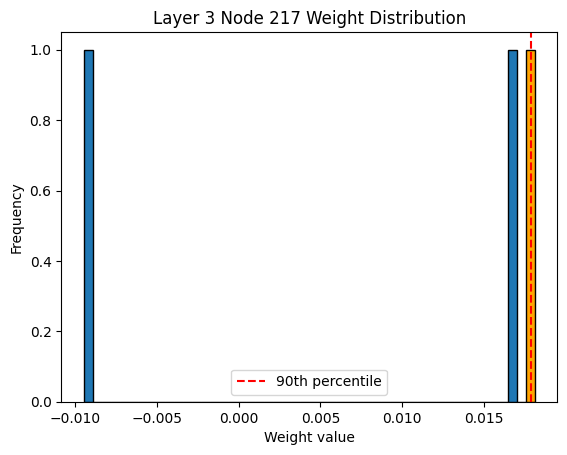

In [32]:


W = fifth_layer.detach().numpy()[:,381]

# print(W)
# print(len(W))

# Compute 90th percentile threshold
threshold = np.percentile(W, 90)

# Plot histogram
counts, bin_edges, patches = plt.hist(W, bins=50, edgecolor='black')

# Count how many weights are in the top 10%
top_10_count = np.sum(W > threshold)

# Highlight bins that start above the 90th percentile
for i in range(len(patches)):
    bin_left = bin_edges[i]
    bin_right = bin_edges[i+1]
    
    # If the bin overlaps with the top 10% range
    if bin_right > threshold:
        patches[i].set_facecolor('orange')  # Highlight color

# Add plot labels
plt.title(f"Layer 3 Node {col} Weight Distribution")
plt.xlabel("Weight value")
plt.ylabel("Frequency")

# Optional: Add a vertical line at the threshold
plt.axvline(threshold, color='red', linestyle='--', label='90th percentile')
plt.legend()
#plt.xlim(-0.1, 0.1)

plt.show()

In [33]:
W = fifth_layer.detach().numpy()[:,381]
print(W)

[-0.00945556  0.01808528  0.0168539 ]


[-0.1998128   0.17513919 -0.1319925  -0.20062828  0.04089496  0.1870508
 -0.06472185 -0.07028652 -0.24465942  0.07526223  0.23649448  0.14803325
 -0.07977153 -0.2169707  -0.03071824 -0.07706574 -0.23943804  0.1151267
 -0.02949236 -0.16083886 -0.03418399 -0.04710616 -0.07352282 -0.17363931
  0.22110371  0.14614941  0.05583746 -0.22374326  0.06032417 -0.03635943
  0.1339636   0.232964   -0.18660906 -0.04920603 -0.05940389 -0.03809941
  0.13876133 -0.12413648  0.19348642 -0.07313628  0.12456421 -0.21541229
  0.06514941  0.06639923  0.05297076  0.11421     0.12291023 -0.16504122
  0.2251743  -0.09457178 -0.10874945  0.05760404 -0.00341082 -0.09672322
  0.01760331  0.24634385  0.25410494  0.21314354 -0.05105926 -0.10948739
  0.0844263  -0.12623292  0.23417658  0.04016981  0.24320842 -0.20623128
 -0.24842675 -0.01221814  0.00144019  0.13989258 -0.0990973  -0.20042777
 -0.05015827  0.01071089 -0.08387938 -0.16326204 -0.18277453 -0.03062764
 -0.0584424   0.17662302 -0.21383838  0.11829601  0.0

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_75693/1296942691.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


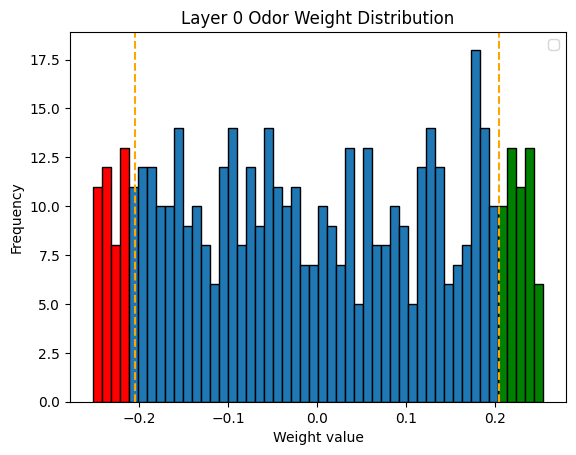

In [34]:
W = first_layer.detach().numpy()[:,0]

print(W)
print(len(W))

# Compute 10th percentile threshold
b_threshold = np.percentile(W, 10)
t_threshold = np.percentile(W, 90)

# Plot histogram
counts, bin_edges, patches = plt.hist(W, bins=50, edgecolor='black')

for i in range(len(patches)):
    bin_left = bin_edges[i]
    bin_right = bin_edges[i+1]
    

    if bin_right > t_threshold:
        patches[i].set_facecolor('green')  # Highlight color
    if bin_right < b_threshold:
        patches[i].set_facecolor('red')

# Add plot labels
plt.title("Layer 0 Odor Weight Distribution")
plt.xlabel("Weight value")
plt.ylabel("Frequency")

# Optional: Add a vertical line at the threshold
plt.axvline(t_threshold, color='orange', linestyle='--')
plt.axvline(b_threshold, color='orange', linestyle='--')
plt.legend()
plt.show()

In [35]:
W = first_layer.detach().numpy()[:,0]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.245
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.24465942 -0.2169707  -0.23943804 -0.22374326 -0.21541229 -0.20623128
 -0.24842675 -0.21383838 -0.20871077 -0.22907908 -0.24773754 -0.2208504
 -0.24153273 -0.20466411 -0.21276113 -0.23672609 -0.21290077 -0.2095537
 -0.23803645 -0.21147425 -0.22783293 -0.24832487 -0.22428453 -0.22239116
 -0.22805656 -0.21159598 -0.20765743 -0.21880873 -0.21403097 -0.23275903
 -0.25241306 -0.24996547 -0.23379178 -0.247989   -0.2177436  -0.23226754
 -0.24666466 -0.24266928 -0.20553437 -0.22452983 -0.23859555 -0.23393802
 -0.21517877 -0.2381903  -0.22705103 -0.24556035 -0.23540188 -0.24445818
 -0.21684875 -0.2182486  -0.23901577 -0.21557935]
-0.25241306
270
[ 66 120 218 270 273 290 309 439]


In [36]:
for col in [66,120,218,270,273,290,309,439]:
    
    print(col)
    W = second_layer.detach().numpy()[:,col]

    # Compute 10th percentile threshold
    threshold = np.percentile(W, 10)

    top_10_percent = W[W < threshold]
    print(top_10_percent)
    # mean = np.mean(top_10_percent)
    # max_val = max(top_10_percent)
    # min_val = min(top_10_percent)
    # std = np.std(top_10_percent)
    # print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

66
[-0.04344068 -0.04475595 -0.04155403 -0.05272463 -0.03910961 -0.04324125
 -0.04316102 -0.04334405 -0.04316041 -0.04472375 -0.0478562  -0.03894193
 -0.04101868 -0.0403087  -0.0476088  -0.04502859 -0.04631485 -0.03976054
 -0.04679769 -0.04002236 -0.0396537  -0.04113765 -0.04289047 -0.05247459
 -0.0396605  -0.03864307 -0.04688274 -0.04068666 -0.0393589  -0.04730738
 -0.05400361 -0.04264056 -0.03866192 -0.04487478 -0.04101627 -0.04933621
 -0.05140966 -0.04426851 -0.04761231 -0.03969617 -0.05745587 -0.04629917
 -0.04453708 -0.03947166 -0.04604138 -0.04259929 -0.04350813 -0.0472371
 -0.04558609 -0.04110702 -0.04921133 -0.04534837]
120
[-0.03762912 -0.03766099 -0.04415906 -0.04683216 -0.03766748 -0.04833419
 -0.04178512 -0.0547963  -0.05197524 -0.04272706 -0.04001079 -0.04511949
 -0.04357673 -0.04090239 -0.04355553 -0.04632841 -0.05148317 -0.05419361
 -0.03914358 -0.03627903 -0.0424397  -0.03559408 -0.04538133 -0.05168839
 -0.03674884 -0.04124093 -0.04096582 -0.0352304  -0.04180752 -0.0371

In [37]:
W = second_layer.detach().numpy()[:,270]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.053
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.03844246 -0.05110475 -0.03877012 -0.0489052  -0.04894153 -0.04424817
 -0.05065051 -0.04411471 -0.04658385 -0.04633345 -0.04953261 -0.04133052
 -0.04675169 -0.04665854 -0.03818341 -0.04972133 -0.05609304 -0.03736697
 -0.04033858 -0.03835416 -0.04721704 -0.04277121 -0.03812153 -0.03989988
 -0.05052248 -0.04672265 -0.04340036 -0.045305   -0.04416917 -0.03858773
 -0.04395527 -0.03895409 -0.04157708 -0.04860068 -0.03948042 -0.03965699
 -0.05052215 -0.05335601 -0.04696758 -0.04251719 -0.03916777 -0.03779944
 -0.04091784 -0.04168746 -0.04193128 -0.03933879 -0.04363219 -0.04325663
 -0.03954833 -0.05218711 -0.04283667 -0.03861101]
-0.05609304
214
[214 415]


In [38]:
for col in [214, 415]:
    W = third_layer.detach().numpy()[:,col]

    # Compute 10th percentile threshold
    threshold = np.percentile(W, 10)

    top_10_percent = W[W < threshold]
    #print(top_10_percent)
    mean = np.mean(top_10_percent)
    max_val = max(top_10_percent)
    min_val = min(top_10_percent)
    std = np.std(top_10_percent)
    print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

Mean: -0.04549
Std: 0.00647
Max: -0.03836
Min: -0.06829



Mean: -0.04261
Std: 0.00575
Max: -0.03510
Min: -0.06580





In [39]:
W = third_layer.detach().numpy()[:,214]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.06
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.06829433 -0.03864812 -0.03908474 -0.04270065 -0.04279824 -0.04842402
 -0.03957931 -0.0520764  -0.04300839 -0.04467618 -0.03880459 -0.0401575
 -0.04088883 -0.04618176 -0.04123779 -0.06098588 -0.04859615 -0.04647028
 -0.04368204 -0.04112874 -0.04746484 -0.04562739 -0.04036195 -0.05374745
 -0.04655527 -0.04435106 -0.03850809 -0.04568779 -0.04457792 -0.041228
 -0.04998662 -0.03932691 -0.04852013 -0.06493726 -0.04571202 -0.04528327
 -0.04864983 -0.03836118 -0.04247268 -0.04469455 -0.0416829  -0.06091377
 -0.04329098 -0.03983526 -0.04986397 -0.04764187 -0.04521662 -0.04391395
 -0.03861914 -0.04135994 -0.04682361 -0.04308676]
-0.06829433
0
[  0 204 351 420]


In [40]:
for col in [0, 204, 351, 420]:
    W = fourth_layer.detach().numpy()[:,col]

    # Compute 10th percentile threshold
    threshold = np.percentile(W, 10)

    top_10_percent = W[W < threshold]
    #print(top_10_percent)
    mean = np.mean(top_10_percent)
    max_val = max(top_10_percent)
    min_val = min(top_10_percent)
    std = np.std(top_10_percent)
    print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

Mean: -0.04527
Std: 0.00623
Max: -0.03838
Min: -0.06733



Mean: -0.04233
Std: 0.00705
Max: -0.03415
Min: -0.06942



Mean: -0.04752
Std: 0.00694
Max: -0.03966
Min: -0.06851



Mean: -0.04953
Std: 0.00955
Max: -0.04121
Min: -0.07785





In [41]:
W = fourth_layer.detach().numpy()[:,420]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.075
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.07696348 -0.05037292 -0.05611593 -0.0413788  -0.04371601 -0.04174644
 -0.04210924 -0.05260836 -0.04219591 -0.05279944 -0.04229426 -0.0469753
 -0.04310134 -0.07785112 -0.04362635 -0.04720272 -0.04931666 -0.07383061
 -0.04197196 -0.04504258 -0.04444044 -0.04324337 -0.04500601 -0.04905603
 -0.05780594 -0.04191892 -0.04668517 -0.04652969 -0.06415764 -0.06338365
 -0.04856876 -0.04764246 -0.04121005 -0.04554957 -0.04283826 -0.05633671
 -0.06240814 -0.05648776 -0.04327469 -0.04368988 -0.04438158 -0.04267715
 -0.04201997 -0.07423817 -0.04257732 -0.04339062 -0.04664186 -0.05296844
 -0.04443594 -0.04309598 -0.04482877 -0.05259856]
-0.07785112
107
[  9 107]


In [42]:
for col in [9, 107]:
    W = fifth_layer.detach().numpy()[:,col]

    print(W)

[-0.07539783 -0.01413769  0.03319212]
[-0.04174684 -0.03050587  0.03857293]


## Odor Negative Weight Analysis v2

In [43]:
W = first_layer.detach().numpy()[:,0]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.245
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.24465942 -0.2169707  -0.23943804 -0.22374326 -0.21541229 -0.20623128
 -0.24842675 -0.21383838 -0.20871077 -0.22907908 -0.24773754 -0.2208504
 -0.24153273 -0.20466411 -0.21276113 -0.23672609 -0.21290077 -0.2095537
 -0.23803645 -0.21147425 -0.22783293 -0.24832487 -0.22428453 -0.22239116
 -0.22805656 -0.21159598 -0.20765743 -0.21880873 -0.21403097 -0.23275903
 -0.25241306 -0.24996547 -0.23379178 -0.247989   -0.2177436  -0.23226754
 -0.24666466 -0.24266928 -0.20553437 -0.22452983 -0.23859555 -0.23393802
 -0.21517877 -0.2381903  -0.22705103 -0.24556035 -0.23540188 -0.24445818
 -0.21684875 -0.2182486  -0.23901577 -0.21557935]
-0.25241306
270
[ 66 120 218 270 273 290 309 439]


In [44]:
for col in [66,120,218,270,273,290,309,439]:
    
    print(col)
    W = second_layer.detach().numpy()[:,col]

    # Compute 10th percentile threshold
    threshold = np.percentile(W, 10)

    top_10_percent = W[W < threshold]
    #print(top_10_percent)
    min_threshold = -0.08
    indices = np.where(W < min_threshold)[0]
    print(indices)  
    # mean = np.mean(top_10_percent)
    # max_val = max(top_10_percent)
    # min_val = min(top_10_percent)
    # std = np.std(top_10_percent)
    # print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

66
[]
120
[]
218
[]
270
[]
273
[]
290
[]
309
[]
439
[ 31 220 227]


In [45]:
W = second_layer.detach().numpy()[:,439]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.08
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.07098477 -0.04729671 -0.06964066 -0.06511015 -0.07804134 -0.05279385
 -0.06528524 -0.0811152  -0.06030334 -0.06272535 -0.04451073 -0.04724117
 -0.06697813 -0.04836307 -0.04683078 -0.05457677 -0.07587951 -0.05387205
 -0.06087565 -0.0582802  -0.06028527 -0.07266656 -0.05128177 -0.05528342
 -0.05365843 -0.04936499 -0.05236341 -0.04683159 -0.09168084 -0.08282237
 -0.06451738 -0.07327914 -0.04357394 -0.04533836 -0.04818023 -0.0500485
 -0.04994331 -0.05434747 -0.04943319 -0.05682383 -0.04521636 -0.05502277
 -0.0500319  -0.06759888 -0.04645654 -0.07158127 -0.06466614 -0.05784834
 -0.04363532 -0.06867892 -0.07506636 -0.06088565]
-0.09168084
220
[ 31 220 227]


In [46]:
for col in [31, 220, 227]:
    
    print(col)
    W = third_layer.detach().numpy()[:,col]

    # Compute 10th percentile threshold
    threshold = np.percentile(W, 10)

    top_10_percent = W[W < threshold]
    #print(top_10_percent)
    # mean = np.mean(top_10_percent)
    # max_val = max(top_10_percent)
    # min_val = min(top_10_percent)
    # std = np.std(top_10_percent)
    min_threshold = -0.08
    indices = np.where(W < min_threshold)[0]
    print(indices)  
    # print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

31
[76]
220
[224]
227
[]


In [47]:
W = third_layer.detach().numpy()[:,31]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.08
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.04081354 -0.05376646 -0.03530899 -0.04742632 -0.0439392  -0.03803318
 -0.04205795 -0.08883668 -0.04348652 -0.03696072 -0.05325071 -0.04372137
 -0.04079135 -0.04039805 -0.04051391 -0.03771045 -0.04287961 -0.0603657
 -0.03699771 -0.04544593 -0.04355329 -0.03889704 -0.05199685 -0.04194374
 -0.0423449  -0.03680497 -0.04045454 -0.04105381 -0.03591026 -0.03881562
 -0.05840921 -0.05777786 -0.03757677 -0.04092152 -0.0429048  -0.04520704
 -0.04129439 -0.03840966 -0.03833947 -0.04068246 -0.04558696 -0.03698308
 -0.04176036 -0.0423885  -0.03681415 -0.05025775 -0.03837243 -0.04353505
 -0.04266108 -0.03866809 -0.05233147 -0.0500466 ]
-0.088836685
76
[76]


In [48]:
W = third_layer.detach().numpy()[:,220]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.07
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.0568829  -0.0577619  -0.04152519 -0.05183608 -0.04315007 -0.039863
 -0.04448853 -0.05165446 -0.04976619 -0.04063879 -0.04553737 -0.0460408
 -0.03918379 -0.04143887 -0.04521915 -0.05416292 -0.04424572 -0.05362454
 -0.07436812 -0.06044833 -0.04935812 -0.03887475 -0.04126053 -0.06754
 -0.08266898 -0.05166826 -0.038941   -0.04565031 -0.04583079 -0.04445394
 -0.057681   -0.0445952  -0.0532967  -0.04013553 -0.04584497 -0.03934812
 -0.04394988 -0.04028868 -0.04457888 -0.04093697 -0.04072329 -0.04124953
 -0.04355224 -0.04754696 -0.04344629 -0.04829459 -0.04036556 -0.04411983
 -0.04111581 -0.03928312 -0.05054668 -0.04511476]
-0.08266898
224
[164 224]


In [49]:
W = third_layer.detach().numpy()[:,227]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.07
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.06979447 -0.0474414  -0.075794   -0.04766201 -0.04117673 -0.05801735
 -0.04351771 -0.04219331 -0.04419081 -0.04068764 -0.06204991 -0.04531206
 -0.04102956 -0.04812636 -0.04230135 -0.04627123 -0.0426939  -0.04439706
 -0.04349585 -0.06729456 -0.05110329 -0.04638978 -0.04234323 -0.04043271
 -0.04028744 -0.04584904 -0.06359716 -0.04138181 -0.07568769 -0.04547991
 -0.07313116 -0.04162398 -0.04411468 -0.04262292 -0.06414236 -0.06540789
 -0.05039825 -0.04633322 -0.0484201  -0.04668364 -0.06463064 -0.04871264
 -0.04186181 -0.04093596 -0.04672498 -0.05639368 -0.05383813 -0.04450059
 -0.04204328 -0.04257166 -0.05515918 -0.04186661]
-0.075794004
15
[ 15 250 274]


In [50]:
for col in [76, 224]:
    
    print(col)
    W = fourth_layer.detach().numpy()[:,col]

    # Compute 10th percentile threshold
    threshold = np.percentile(W, 10)

    top_10_percent = W[W < threshold]
    print(top_10_percent)
    min_threshold = -0.065
    indices = np.where(W < min_threshold)[0]
    print(indices)  
    # mean = np.mean(top_10_percent)
    # max_val = max(top_10_percent)
    # min_val = min(top_10_percent)
    # std = np.std(top_10_percent)
    # print(f'Mean: {mean:.5f}\nStd: {std:.5f}\nMax: {max_val:.5f}\nMin: {min_val:.5f}\n\n\n')

76
[-0.04292641 -0.04170194 -0.044912   -0.06247823 -0.04730904 -0.04077506
 -0.03642759 -0.04359515 -0.03913816 -0.04156135 -0.0455567  -0.04061568
 -0.0372842  -0.03782623 -0.06967776 -0.04443824 -0.04493381 -0.0514315
 -0.04057474 -0.03630741 -0.04042967 -0.05373053 -0.06416543 -0.03845484
 -0.05200391 -0.06387869 -0.05014176 -0.06469506 -0.03799907 -0.03580008
 -0.04329512 -0.0418243  -0.06747635 -0.03717386 -0.04147799 -0.05324322
 -0.04113981 -0.03607541 -0.03774016 -0.04009995 -0.05393119 -0.04235965
 -0.05215945 -0.03635499 -0.04854492 -0.04000232 -0.03699668 -0.03998958
 -0.03920216 -0.04038961 -0.04081631 -0.05546969]
[168 325]
224
[-0.03858796 -0.04914755 -0.04820609 -0.03907941 -0.03975814 -0.04262381
 -0.04232159 -0.03801434 -0.0425288  -0.04294877 -0.04004591 -0.04175038
 -0.04082751 -0.04935529 -0.0445706  -0.03768519 -0.04443514 -0.04849227
 -0.03850156 -0.03748352 -0.04034261 -0.04333049 -0.04071074 -0.03825176
 -0.04134015 -0.037442   -0.04309874 -0.04473723 -0.044054

In [51]:
W = fourth_layer.detach().numpy()[:,164]
b_threshold = np.percentile(W, 10)

bot_10_percent = W[W < b_threshold]
print(bot_10_percent)
min_weight = min(bot_10_percent)
print(min_weight)
index = np.where(W == min_weight)[0][0]
print(index)

min_threshold = -0.05
indices = np.where(W < min_threshold)[0]
print(indices)  

[-0.04520205 -0.04204047 -0.0596907  -0.04373838 -0.04741864 -0.04190917
 -0.03868979 -0.04375963 -0.03587975 -0.03943089 -0.03509779 -0.04638123
 -0.03923039 -0.04223597 -0.04221842 -0.03552368 -0.03592919 -0.03964085
 -0.04441072 -0.04668201 -0.04236265 -0.04045361 -0.04047516 -0.04090816
 -0.04901114 -0.03631075 -0.03647664 -0.04481725 -0.04051273 -0.03892373
 -0.03674806 -0.04635221 -0.03570062 -0.04199864 -0.04330035 -0.0472219
 -0.03554853 -0.03553639 -0.04608732 -0.04376677 -0.04687855 -0.03804717
 -0.03861878 -0.053781   -0.03518156 -0.04745631 -0.03612604 -0.04861401
 -0.03567057 -0.0381039  -0.03504825 -0.04008206]
-0.059690703
31
[ 31 445]


In [52]:
for col in [168, 325]:

    W = fifth_layer.detach().numpy()[:,col]
    print(col)
    print(W)

168
[-0.00076433  0.03773805 -0.0184359 ]
325
[ 0.0360233  -0.02466712  0.02151001]


In [53]:
# Cumulative Odor Sum

pos_odor = [-0.00945556,0.01808528,0.0168539 ]
neg_odor1 = [-0.00076433,0.03773805,-0.0184359 ]
neg_odor2 = [ 0.0360233,-0.02466712,0.02151001]

sum_weight = [x+y+z for x,y,z in zip(pos_odor,neg_odor1,neg_odor2)]
sum_weight

[0.02580341, 0.031156210000000004, 0.01992801]

## Scatter Plots

In [54]:
first_layer = weights[0]
second_layer = weights[1]
third_layer = weights[2]
fourth_layer = weights[3]
fifth_layer = weights[4]
print(first_layer.shape)
print(fifth_layer.shape)
first_layer[511]

torch.Size([512, 19])
torch.Size([3, 512])


tensor([-0.2156,  0.0187, -0.0898,  0.1267,  0.1934,  0.1992,  0.0227, -0.1447,
        -0.1592,  0.2109,  0.0100, -0.2239,  0.1154, -0.1566, -0.1918,  0.1054,
         0.1506,  0.0837,  0.1684], grad_fn=<SelectBackward0>)

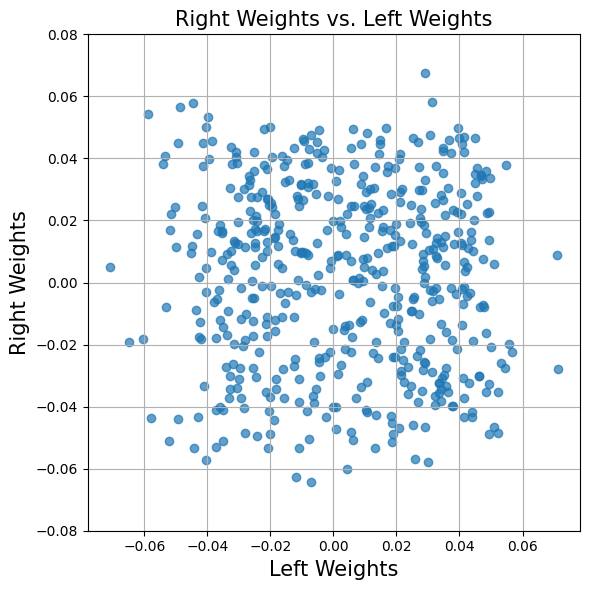

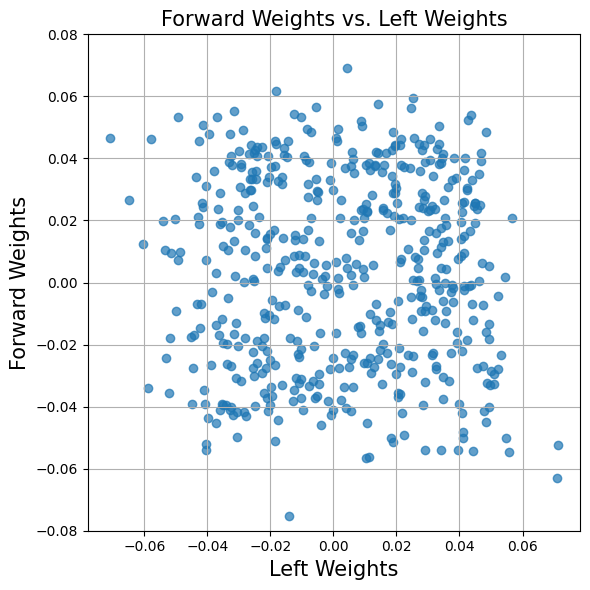

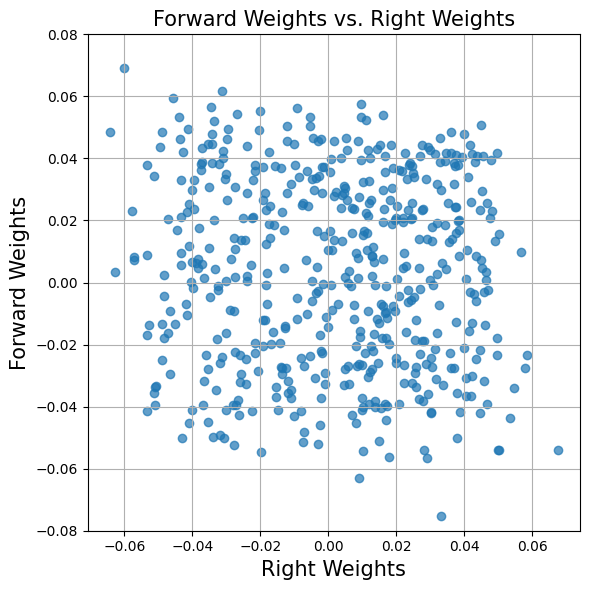

In [55]:
forward_weights = fifth_layer[0].detach().numpy()
left_weights = fifth_layer[1].detach().numpy()
right_weights = fifth_layer[2].detach().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(left_weights, right_weights, alpha=0.7)
plt.xlabel('Left Weights', fontsize=15)
plt.ylabel('Right Weights',fontsize=15)
plt.title('Right Weights vs. Left Weights',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.ylim(-0.08,0.08)
plt.savefig('figures/RvLscatter.png', dpi = 500)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(left_weights, forward_weights, alpha=0.7)
plt.xlabel('Left Weights',fontsize=15)
plt.ylabel('Forward Weights',fontsize=15)
plt.title('Forward Weights vs. Left Weights',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.ylim(-0.08,0.08)
plt.savefig('figures/FvLscatter.png', dpi = 500)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(right_weights, forward_weights, alpha=0.7)
plt.xlabel('Right Weights',fontsize=15)
plt.ylabel('Forward Weights',fontsize=15)
plt.title('Forward Weights vs. Right Weights',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.ylim(-0.08,0.08)
plt.savefig('figures/FvRscatter.png', dpi = 500)
plt.show()

## Heatmaps

In [56]:
net = data_dict_20['net']
env = data_dict_20['env']
biases = data_dict_20['biases']
p = data_dict_20["p"]

In [57]:
untrained_net, _ = neural_network(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        nHiddenUnits=p.n_hidden_units,
    )
weights_untrained = [layer.detach() for layer in untrained_net.parameters()]
weights_trained = [layer for layer in net.parameters()]

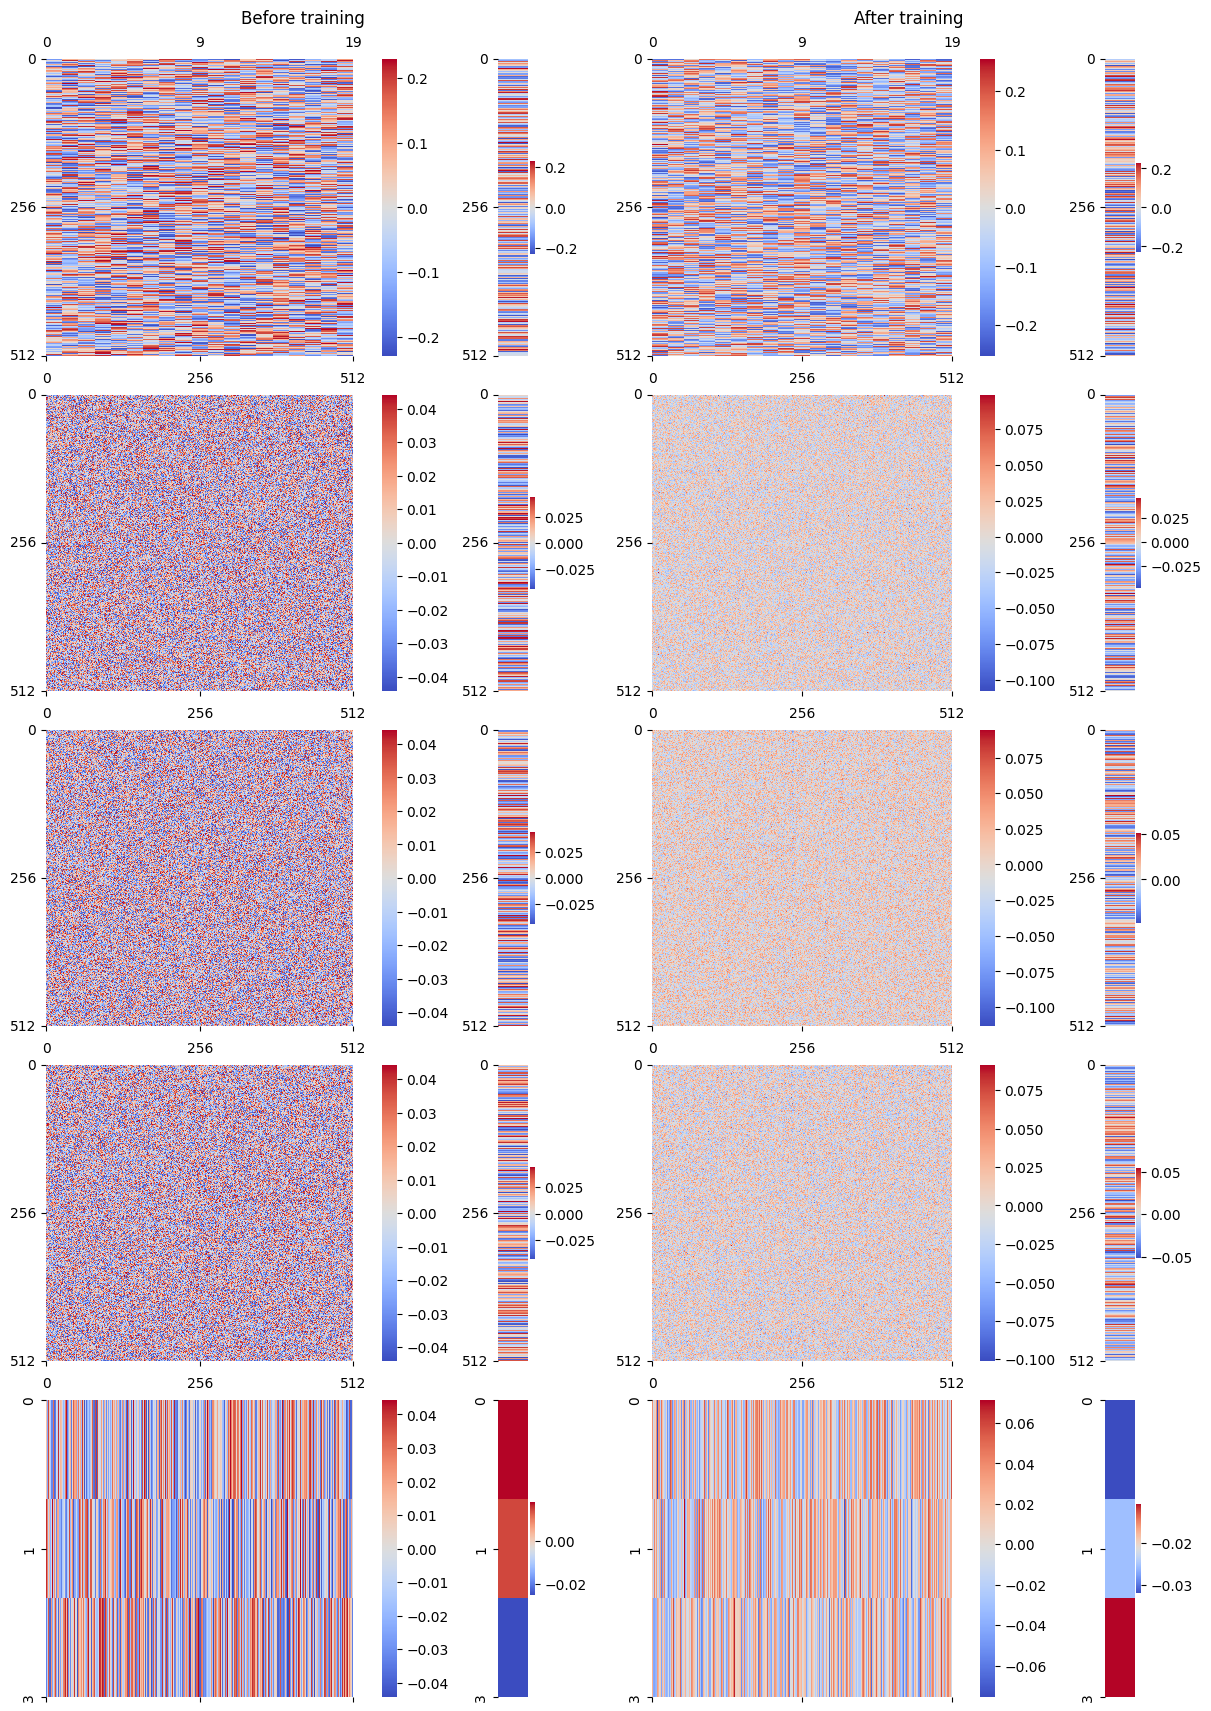

In [58]:
fig = plt.figure(layout="constrained", figsize=(12, 17))
subfigs = fig.subfigures(nrows=1, ncols=2)
ax = []
for subf in subfigs:
    ax.append(
        subf.subplots(
            nrows=round(len(weights_trained) / 2),
            ncols=2,
            width_ratios=[10, 1],
        )
    )
subfigs[0].suptitle("Before training")
subfigs[1].suptitle("After training")
# subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')
# subfigs[1].colorbar(pc, shrink=0.6, ax=axsRight)
# fig.suptitle('Weights')

for idx, (w_untrained, w_trained) in enumerate(
    zip(weights_untrained, weights_trained)
):
    # cmap = "bwr"
    cmap = "coolwarm"

    plot_row = int(np.floor(idx / 2))  # Row index to lay out the plots

    if len(w_trained.shape) < 2:  # Biases
        b_untrained_current = w_untrained.unsqueeze(-1).cpu().detach().numpy()
        b_trained_current = w_trained.unsqueeze(-1).cpu().detach().numpy()
        sns.heatmap(b_untrained_current, ax=ax[0][plot_row, 1], cmap=cmap)
        sns.heatmap(b_trained_current, ax=ax[1][plot_row, 1], cmap=cmap)
        for axi in ax:
            axi[plot_row, 1].xaxis.set_major_locator(mpl.ticker.NullLocator())

    else:  # Weights
        w_untrained_current = w_untrained.cpu().detach().numpy()
        w_trained_current = w_trained.cpu().detach().numpy()
        sns.heatmap(w_untrained_current, ax=ax[0][plot_row, 0], cmap=cmap)
        sns.heatmap(w_trained_current, ax=ax[1][plot_row, 0], cmap=cmap)
        for axi in ax:
            axi[plot_row, 0].tick_params(labelbottom=False, labeltop=True)
            axi[plot_row, 0].xaxis.set_major_locator(
                mpl.ticker.LinearLocator(numticks=3)
            )
            for axj in axi.flatten():
                axj.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))

for axlr in ax:
    for axi in axlr:
        for axj in axi:
            axj.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
            axj.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))

    # fig.tight_layout()
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
fig.savefig('figures/weights_heatmap.png', bbox_inches="tight")
plt.show()

tensor([ 0.0177,  0.0142, -0.0250])
Parameter containing:
tensor([-0.0321, -0.0255, -0.0104], requires_grad=True)


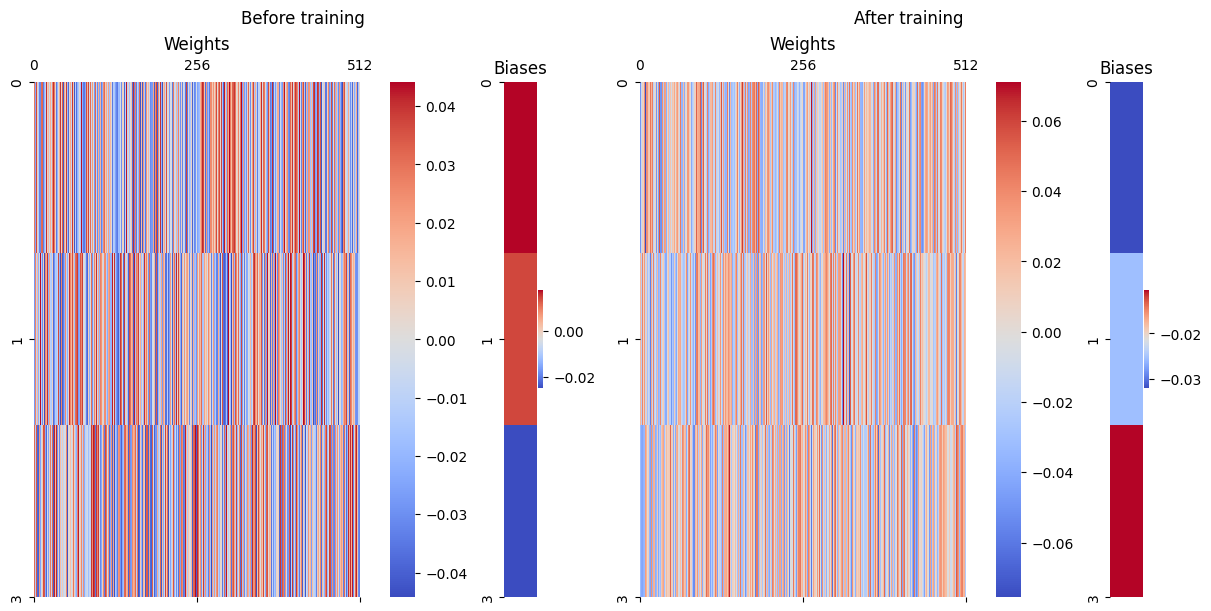

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

# Extract final layer weights and biases
w_untrained = weights_untrained[-2]
w_trained = weights_trained[-2]
b_untrained = weights_untrained[-1]
b_trained = weights_trained[-1]
print(b_untrained)
print(b_trained)

# Convert to numpy
w_untrained_np = w_untrained.cpu().detach().numpy()
w_trained_np = w_trained.cpu().detach().numpy()
b_untrained_np = b_untrained.unsqueeze(-1).cpu().detach().numpy()
b_trained_np = b_trained.unsqueeze(-1).cpu().detach().numpy()

cmap = "coolwarm"

# Create figure
fig = plt.figure(layout="constrained", figsize=(12, 6))
subfigs = fig.subfigures(nrows=1, ncols=2)
ax = []
for subf in subfigs:
    ax.append(subf.subplots(nrows=1, ncols=2, width_ratios=[10, 1]))  # [weights, biases]

subfigs[0].suptitle("Before training")
subfigs[1].suptitle("After training")

# Plot weights
sns.heatmap(w_untrained_np, ax=ax[0][0], cmap=cmap)
sns.heatmap(w_trained_np, ax=ax[1][0], cmap=cmap)
for axi in [ax[0][0], ax[1][0]]:
    axi.tick_params(labelbottom=False, labeltop=True)
    axi.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
    axi.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
    axi.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
    axi.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
    axi.set_title("Weights")

# Plot biases
sns.heatmap(b_untrained_np, ax=ax[0][1], cmap=cmap)
sns.heatmap(b_trained_np, ax=ax[1][1], cmap=cmap)
for axi in [ax[0][1], ax[1][1]]:
    axi.xaxis.set_major_locator(mpl.ticker.NullLocator())
    axi.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
    axi.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
    axi.set_title("Biases")

# Final touches
fig.patch.set_alpha(0)
fig.patch.set_facecolor("white")
fig.savefig("figures/last_layer_weights_heatmap.png", bbox_inches="tight")
plt.show()


tensor([ 0.0177,  0.0142, -0.0250])
Parameter containing:
tensor([-0.0321, -0.0255, -0.0104], requires_grad=True)


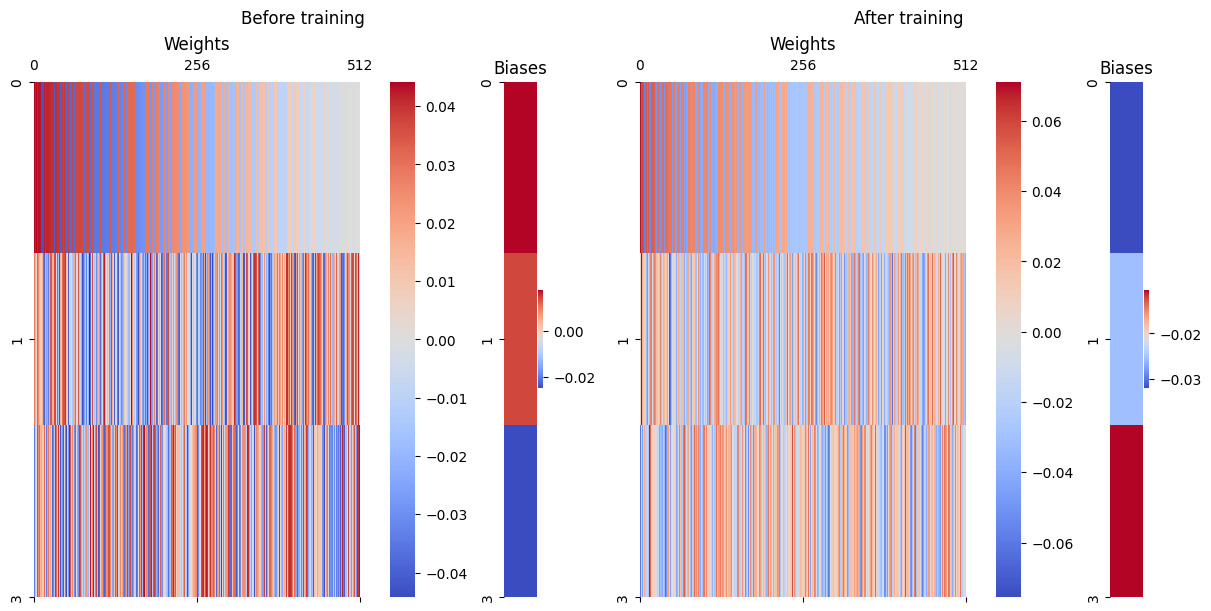

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

# Extract final layer weights and biases
w_untrained = weights_untrained[-2]
w_trained = weights_trained[-2]
b_untrained = weights_untrained[-1]
b_trained = weights_trained[-1]
print(b_untrained)
print(b_trained)

def reorder_columns_by_first_row_magnitude(matrix):
    # Get sorting indices from absolute values of the first row
    #print(np.abs(matrix[0]))
    sort_idx = np.argsort(-np.abs(matrix[0]))  # descending
    #print(sort_idx)
    return matrix[:, sort_idx], sort_idx

# Convert to numpy and sort columns by first row magnitude
w_untrained_np_raw = w_untrained.cpu().detach().numpy()
w_trained_np_raw = w_trained.cpu().detach().numpy()
# print(w_untrained_np_raw.shape)
# print(w_trained_np_raw.shape)

# Apply the same column reordering to both
w_untrained_np, sort_idx = reorder_columns_by_first_row_magnitude(w_untrained_np_raw)
w_trained_np, sort_idx = reorder_columns_by_first_row_magnitude(w_trained_np_raw)
# print(w_untrained_np.shape)
# print(w_trained_np.shape)

# Biases are not affected by column ordering
b_untrained_np = b_untrained.unsqueeze(-1).cpu().detach().numpy()
b_trained_np = b_trained.unsqueeze(-1).cpu().detach().numpy()

cmap = "coolwarm"

# Create figure
fig = plt.figure(layout="constrained", figsize=(12, 6))
subfigs = fig.subfigures(nrows=1, ncols=2)
ax = []
for subf in subfigs:
    ax.append(subf.subplots(nrows=1, ncols=2, width_ratios=[10, 1]))  # [weights, biases]

subfigs[0].suptitle("Before training")
subfigs[1].suptitle("After training")

# Plot weights
sns.heatmap(w_untrained_np, ax=ax[0][0], cmap=cmap)
sns.heatmap(w_trained_np, ax=ax[1][0], cmap=cmap)
for axi in [ax[0][0], ax[1][0]]:
    axi.tick_params(labelbottom=False, labeltop=True)
    axi.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
    axi.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
    axi.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
    axi.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
    axi.set_title("Weights")

# Plot biases
sns.heatmap(b_untrained_np, ax=ax[0][1], cmap=cmap)
sns.heatmap(b_trained_np, ax=ax[1][1], cmap=cmap)
for axi in [ax[0][1], ax[1][1]]:
    axi.xaxis.set_major_locator(mpl.ticker.NullLocator())
    axi.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
    axi.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
    axi.set_title("Biases")

# Final touches
fig.patch.set_alpha(0)
fig.patch.set_facecolor("white")
fig.savefig("figures/last_layer_weights_heatmap.png", bbox_inches="tight")
plt.show()


tensor([ 0.0177,  0.0142, -0.0250])
Parameter containing:
tensor([-0.0321, -0.0255, -0.0104], requires_grad=True)


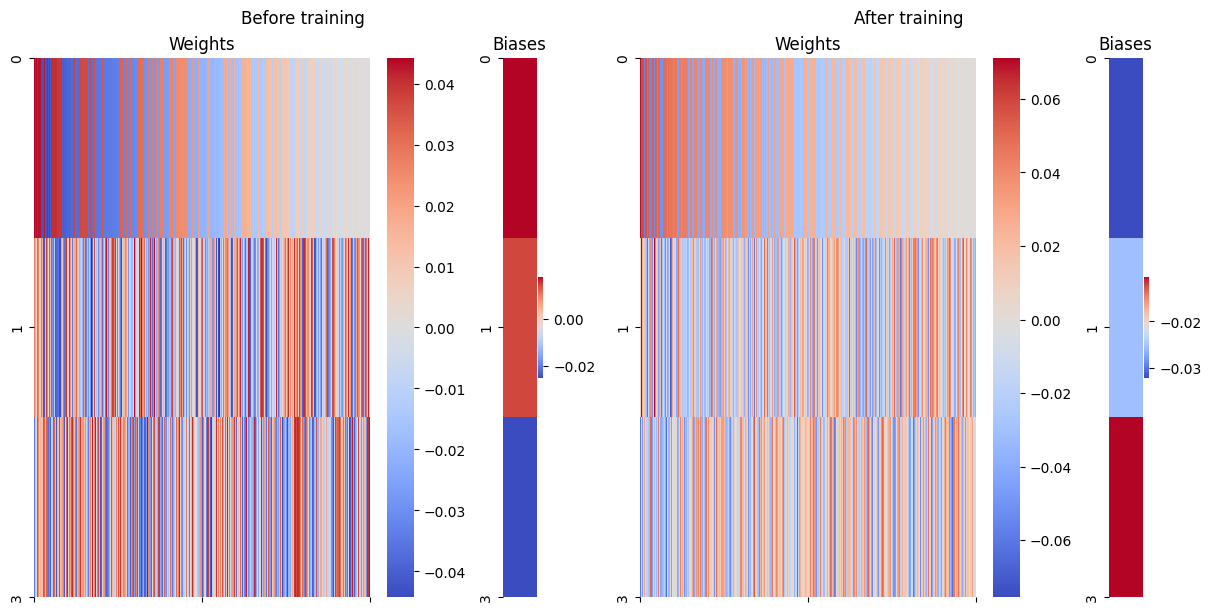

Top 5 original input neurons (before training): [325, 416, 484, 268, 307]
Top 5 original input neurons (after training): [9, 269, 55, 161, 97]


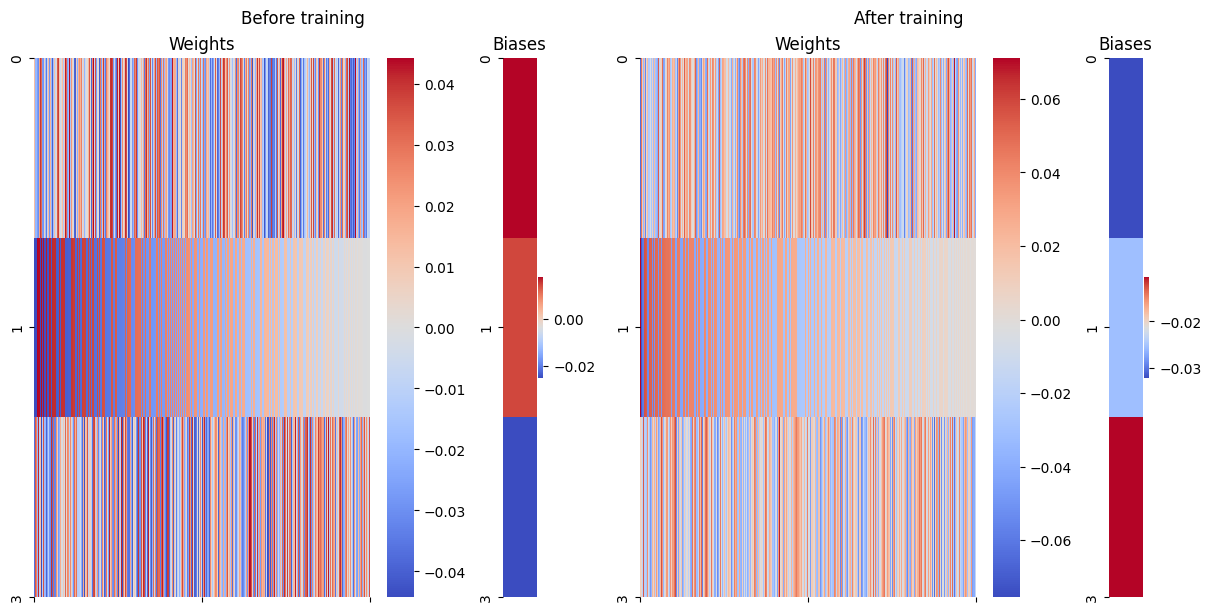

Top 5 original input neurons (before training): [423, 310, 16, 309, 375]
Top 5 original input neurons (after training): [319, 55, 328, 442, 66]


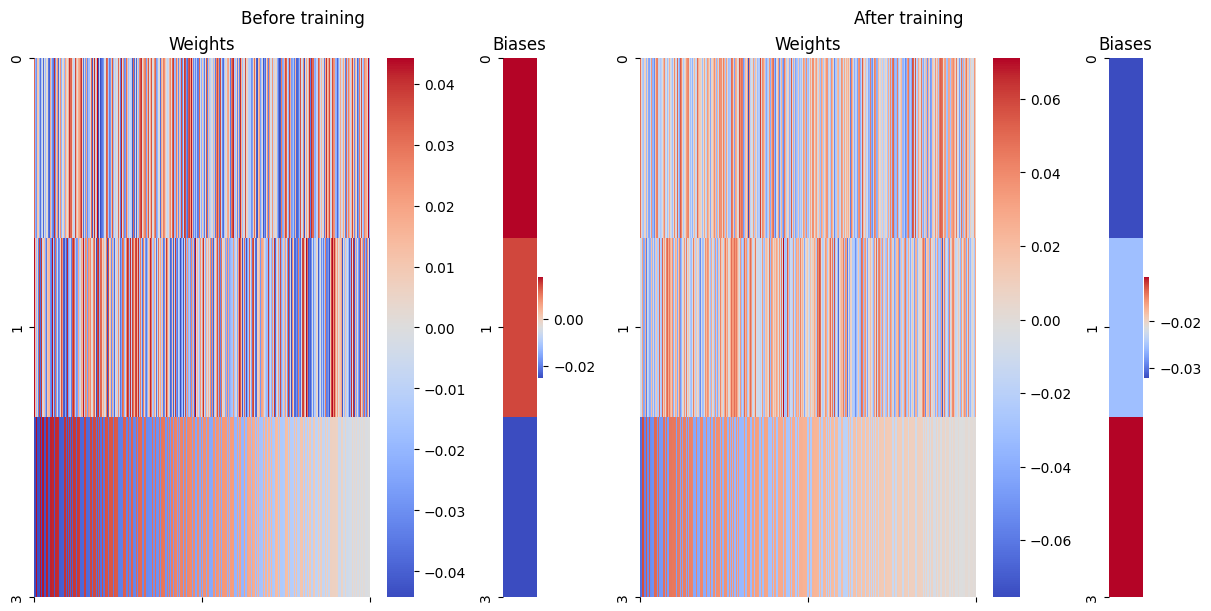

Top 5 original input neurons (before training): [278, 402, 447, 349, 253]
Top 5 original input neurons (after training): [140, 374, 302, 269, 494]


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

def get_top_k_original_neuron_indices(sorted_matrix, sort_idx, k=5, row=0):
    """
    Given a matrix with sorted columns, return the original neuron indices
    corresponding to the top-k values in the specified row.
    """
    values = sorted_matrix[row]
    topk_sorted_indices = np.argsort(-np.abs(values))[:k]  # in sorted column space
    topk_original_indices = sort_idx[topk_sorted_indices]  # map back to original neurons
    return topk_original_indices.tolist()

# Extract final layer weights and biases
w_untrained = weights_untrained[-2]
w_trained = weights_trained[-2]
b_untrained = weights_untrained[-1]
b_trained = weights_trained[-1]
print(b_untrained)
print(b_trained)

for row in [0,1,2]:
    def reorder_columns_by_first_row_magnitude(matrix):
        # Get sorting indices from absolute values of the first row
        #print(np.abs(matrix[0]))
        sort_idx = np.argsort(-np.abs(matrix[row]))  # descending
        #print(sort_idx)
        return matrix[:, sort_idx], sort_idx

    # Convert to numpy and sort columns by first row magnitude
    w_untrained_np_raw = w_untrained.cpu().detach().numpy()
    w_trained_np_raw = w_trained.cpu().detach().numpy()
    # print(w_untrained_np_raw.shape)
    # print(w_trained_np_raw.shape)

    # Apply the same column reordering to both
    w_untrained_np, sort_idx_u = reorder_columns_by_first_row_magnitude(w_untrained_np_raw)
    w_trained_np, sort_idx_t = reorder_columns_by_first_row_magnitude(w_trained_np_raw)
    # print(w_untrained_np.shape)
    # print(w_trained_np.shape)

    # Biases are not affected by column ordering
    b_untrained_np = b_untrained.unsqueeze(-1).cpu().detach().numpy()
    b_trained_np = b_trained.unsqueeze(-1).cpu().detach().numpy()

    cmap = "coolwarm"

    # Create figure
    fig = plt.figure(layout="constrained", figsize=(12, 6))
    subfigs = fig.subfigures(nrows=1, ncols=2)
    ax = []
    for subf in subfigs:
        ax.append(subf.subplots(nrows=1, ncols=2, width_ratios=[10, 1]))  # [weights, biases]

    subfigs[0].suptitle("Before training")
    subfigs[1].suptitle("After training")

    # Plot weights
    sns.heatmap(w_untrained_np, ax=ax[0][0], cmap=cmap)
    sns.heatmap(w_trained_np, ax=ax[1][0], cmap=cmap)
    for axi in [ax[0][0], ax[1][0]]:
        axi.tick_params(labelbottom=False, labeltop=False)
        axi.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
        axi.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
        axi.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
        axi.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
        axi.set_title("Weights")

    # Plot biases
    sns.heatmap(b_untrained_np, ax=ax[0][1], cmap=cmap)
    sns.heatmap(b_trained_np, ax=ax[1][1], cmap=cmap)
    for axi in [ax[0][1], ax[1][1]]:
        axi.xaxis.set_major_locator(mpl.ticker.NullLocator())
        axi.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
        axi.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
        axi.set_title("Biases")

    # Final touches
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    fig.savefig(f"figures/last_layer_weights_heatmap_mag_row{row}.png", bbox_inches="tight", dpi=500)
    plt.show()

    top5_untrained_neurons = get_top_k_original_neuron_indices(w_untrained_np, sort_idx_u, k=5, row=row)
    top5_trained_neurons   = get_top_k_original_neuron_indices(w_trained_np,   sort_idx_t, k=5, row=row)

    print("Top 5 original input neurons (before training):", top5_untrained_neurons)
    print("Top 5 original input neurons (after training):", top5_trained_neurons)

tensor([ 0.0177,  0.0142, -0.0250])
Parameter containing:
tensor([-0.0321, -0.0255, -0.0104], requires_grad=True)


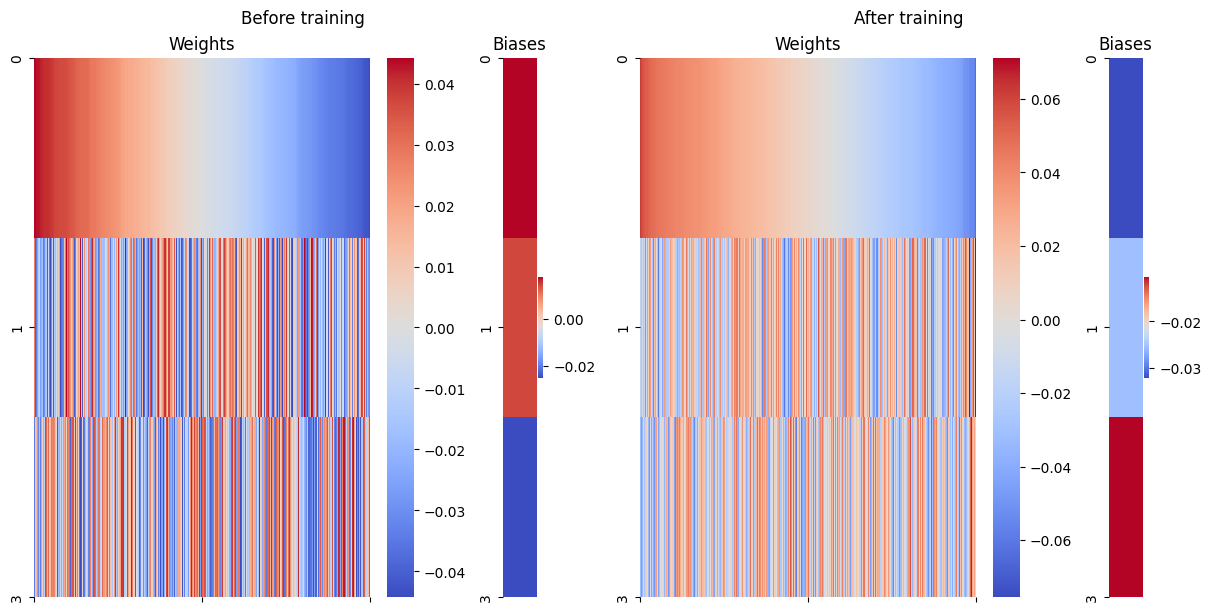

Top 5 original input neurons (before training): [325, 416, 268, 307, 33]
Top 5 original input neurons (after training): [269, 161, 97, 30, 128]


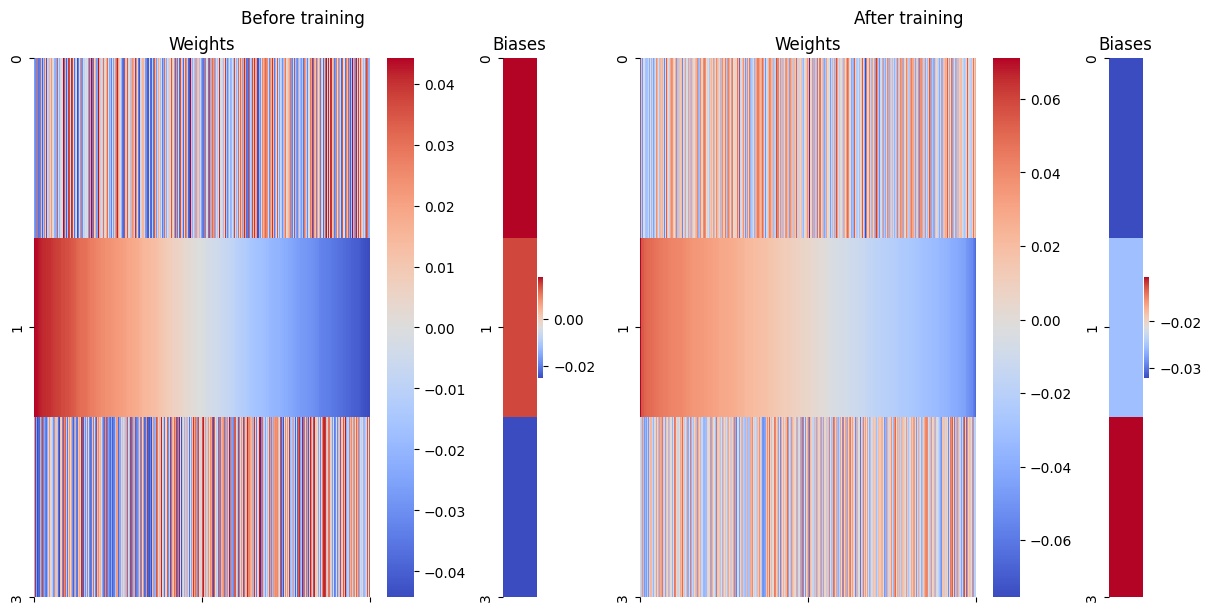

Top 5 original input neurons (before training): [423, 379, 351, 305, 10]
Top 5 original input neurons (after training): [319, 55, 355, 472, 80]


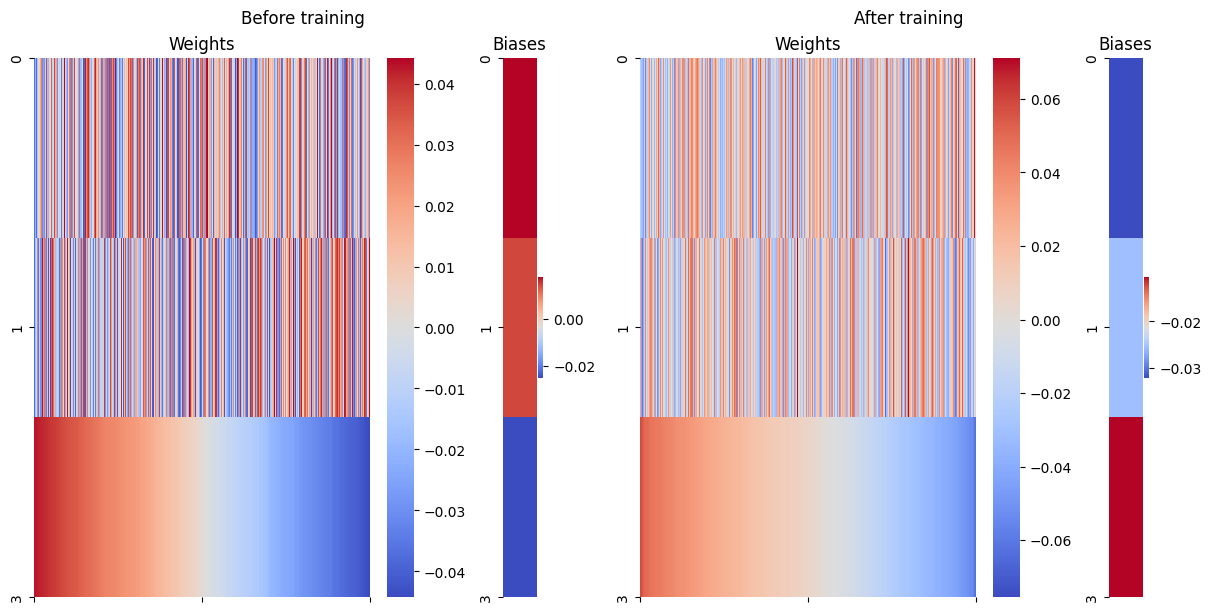

Top 5 original input neurons (before training): [253, 502, 302, 93, 499]
Top 5 original input neurons (after training): [140, 494, 36, 458, 496]


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

def get_top_k_original_neuron_indices(sorted_matrix, sort_idx, k=5, row=0):
    """
    Given a matrix with sorted columns, return the original neuron indices
    corresponding to the top-k values in the specified row.
    """
    values = sorted_matrix[row]
    topk_sorted_indices = np.argsort(-values)[:k]  # in sorted column space
    topk_original_indices = sort_idx[topk_sorted_indices]  # map back to original neurons
    return topk_original_indices.tolist()

# Extract final layer weights and biases
w_untrained = weights_untrained[-2]
w_trained = weights_trained[-2]
b_untrained = weights_untrained[-1]
b_trained = weights_trained[-1]
print(b_untrained)
print(b_trained)

for row in [0,1,2]:
    def reorder_columns_by_first_row_magnitude(matrix, descending=True):
        # Get sorting indices from absolute values of the first row
        #print(np.abs(matrix[0]))
        sort_idx = np.argsort(-matrix[row] if descending else matrix[row]) 
        #print(sort_idx)
        return matrix[:, sort_idx], sort_idx

    # Convert to numpy and sort columns by first row magnitude
    w_untrained_np_raw = w_untrained.cpu().detach().numpy()
    w_trained_np_raw = w_trained.cpu().detach().numpy()
    # print(w_untrained_np_raw.shape)
    # print(w_trained_np_raw.shape)

    # Apply the same column reordering to both
    w_untrained_np, sort_idx_u = reorder_columns_by_first_row_magnitude(w_untrained_np_raw, descending=True)
    w_trained_np, sort_idx_t = reorder_columns_by_first_row_magnitude(w_trained_np_raw, descending=True)
    # print(w_untrained_np.shape)
    # print(w_trained_np.shape)

    # Biases are not affected by column ordering
    b_untrained_np = b_untrained.unsqueeze(-1).cpu().detach().numpy()
    b_trained_np = b_trained.unsqueeze(-1).cpu().detach().numpy()

    cmap = "coolwarm"

    # Create figure
    fig = plt.figure(layout="constrained", figsize=(12, 6))
    subfigs = fig.subfigures(nrows=1, ncols=2)
    ax = []
    for subf in subfigs:
        ax.append(subf.subplots(nrows=1, ncols=2, width_ratios=[10, 1]))  # [weights, biases]

    subfigs[0].suptitle("Before training")
    subfigs[1].suptitle("After training")

    # Plot weights
    sns.heatmap(w_untrained_np, ax=ax[0][0], cmap=cmap)
    sns.heatmap(w_trained_np, ax=ax[1][0], cmap=cmap)
    for axi in [ax[0][0], ax[1][0]]:
        axi.tick_params(labelbottom=False, labeltop=False)
        axi.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
        axi.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
        axi.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
        axi.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
        axi.set_title("Weights")

    # Plot biases
    sns.heatmap(b_untrained_np, ax=ax[0][1], cmap=cmap)
    sns.heatmap(b_trained_np, ax=ax[1][1], cmap=cmap)
    for axi in [ax[0][1], ax[1][1]]:
        axi.xaxis.set_major_locator(mpl.ticker.NullLocator())
        axi.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=3))
        axi.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%d"))
        axi.set_title("Biases")

    # Final touches
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    fig.savefig(f"figures/last_layer_weights_heatmap_sign_row{row}.png", bbox_inches="tight", dpi=500)
    plt.show()

    top5_untrained_neurons = get_top_k_original_neuron_indices(w_untrained_np, sort_idx_u, k=5, row=row)
    top5_trained_neurons   = get_top_k_original_neuron_indices(w_trained_np,   sort_idx_t, k=5, row=row)

    print("Top 5 original input neurons (before training):", top5_untrained_neurons)
    print("Top 5 original input neurons (after training):", top5_trained_neurons)

## Action Node Analysis

In [63]:
first_layer = weights[0]
second_layer = weights[1]
third_layer = weights[2]
fourth_layer = weights[3]
fifth_layer = weights[4]
print(first_layer.shape)
print(fifth_layer.shape)
first_layer[511]

torch.Size([512, 19])
torch.Size([3, 512])


tensor([-0.2156,  0.0187, -0.0898,  0.1267,  0.1934,  0.1992,  0.0227, -0.1447,
        -0.1592,  0.2109,  0.0100, -0.2239,  0.1154, -0.1566, -0.1918,  0.1054,
         0.1506,  0.0837,  0.1684], grad_fn=<SelectBackward0>)

In [76]:
forward_weights = fifth_layer[0].detach().numpy()
left_weights = fifth_layer[1].detach().numpy()
right_weights = fifth_layer[2].detach().numpy()
print(len(forward_weights))

512


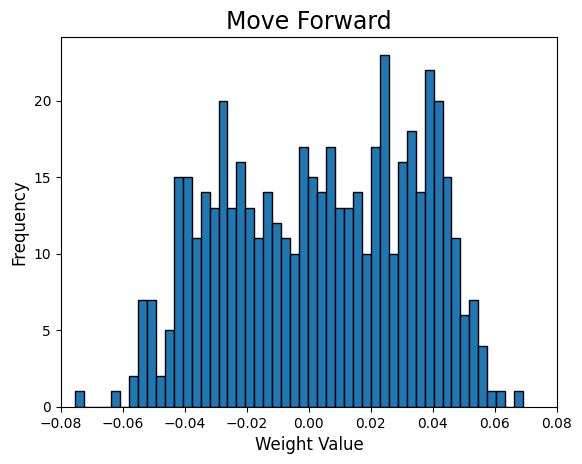

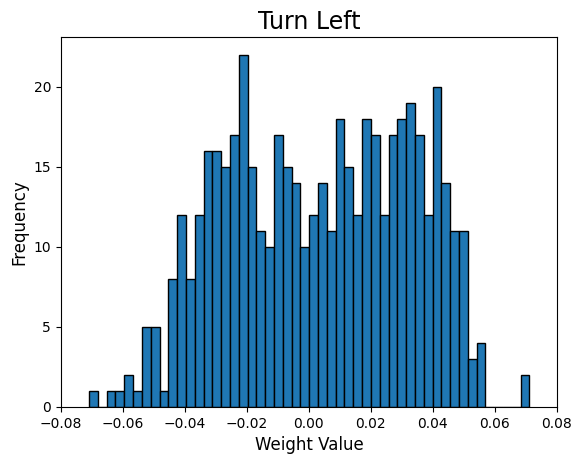

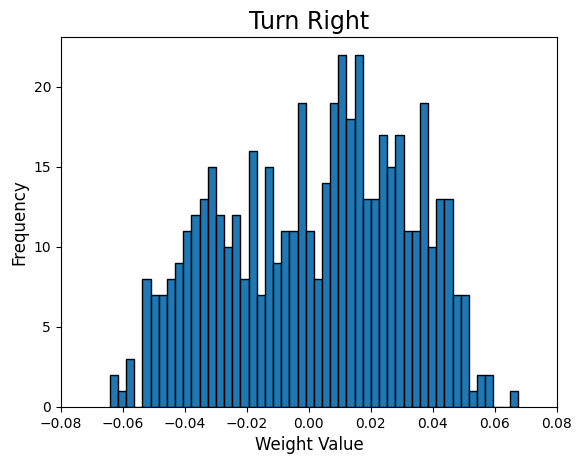

In [81]:
counts, bin_edges, patches = plt.hist(forward_weights, bins=50, edgecolor='black')
plt.xlim(-0.08,0.08)
plt.title("Move Forward", fontsize=17)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Weight Value', fontsize=12)
plt.savefig('figures/forward_hist.png', dpi=500)
plt.show()

counts, bin_edges, patches = plt.hist(left_weights, bins=50, edgecolor='black')
plt.xlim(-0.08,0.08)
plt.title("Turn Left", fontsize=17)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Weight Value', fontsize=12)
plt.savefig('figures/left_hist.png', dpi=500)
plt.show()

counts, bin_edges, patches = plt.hist(right_weights, bins=50, edgecolor='black')
plt.xlim(-0.08,0.08)
plt.title("Turn Right", fontsize=17)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Weight Value', fontsize=12)
plt.savefig('figures/right_hist.png', dpi=500)
plt.show()

In [66]:
for act_weight in [forward_weights, left_weights, right_weights]:    
    threshold = np.percentile(act_weight, 90)
    top_10_percent = act_weight[act_weight > threshold]
    print(top_10_percent)
    max_weight = max(top_10_percent)
    print(max_weight)
    index = np.where(act_weight == max_weight)[0][0]
    print(index)

[0.04640923 0.04321879 0.04198039 0.05744202 0.05524103 0.0443969
 0.05232909 0.05324825 0.0594507  0.05336901 0.05651035 0.04417101
 0.04254289 0.06172275 0.04378176 0.042759   0.04256667 0.04565212
 0.04376615 0.05063567 0.05343732 0.04669354 0.0462753  0.04264903
 0.04865174 0.06911543 0.04308766 0.04638197 0.04644131 0.04657779
 0.0456633  0.04783744 0.04859717 0.05384021 0.0503487  0.04422244
 0.05206956 0.04927991 0.04572893 0.04573227 0.05430872 0.04935583
 0.04791003 0.04848481 0.04468922 0.04456365 0.04935023 0.05053727
 0.04464878 0.04444584 0.04390092 0.05613529]
0.06911543
269
[0.0415624  0.04245713 0.07103167 0.0546864  0.04945528 0.04274148
 0.04505904 0.043788   0.04676586 0.04842481 0.04398813 0.04149867
 0.04419461 0.04611359 0.04458353 0.05208337 0.04702819 0.0543085
 0.0492335  0.04759103 0.0500261  0.05079527 0.04943748 0.04923039
 0.04843099 0.0440474  0.0477265  0.04482285 0.04156955 0.05217807
 0.04331982 0.04961463 0.04242078 0.07114645 0.04632667 0.05311465
 0.

In [67]:
#Top 5 original input neurons (after training): [269, 161, 97, 30, 128]

In [68]:
for act_weight in [forward_weights, left_weights, right_weights]:    
    # threshold = np.percentile(act_weight, 90)
    # top_10_percent = act_weight[act_weight > threshold]
    # print(top_10_percent)
    top_weight_idx = np.argsort(-act_weight)
    print(top_weight_idx[:5])
    # print(max_weight)
    # index = np.where(act_weight == max_weight)[0][0]
    # print(index)

[269 161  97  30 128]
[319  55 355 472  80]
[140 494  36 458 496]


In [74]:
fifth_layer[:,55].detach().numpy()

array([-0.06297347,  0.07103167,  0.00889321], dtype=float32)

## Histogram Comparisons

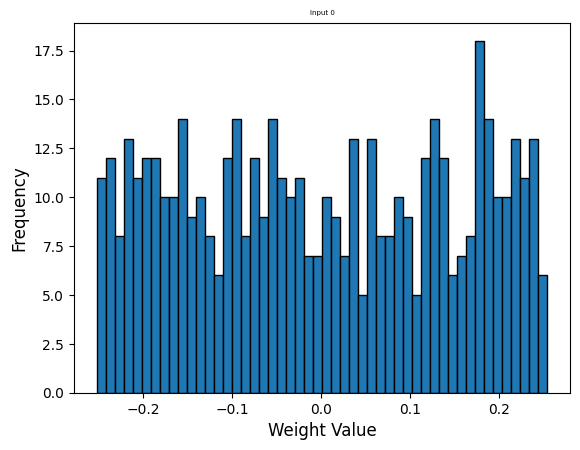

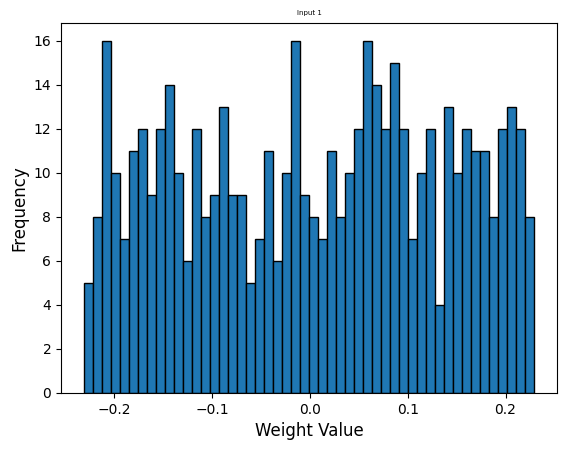

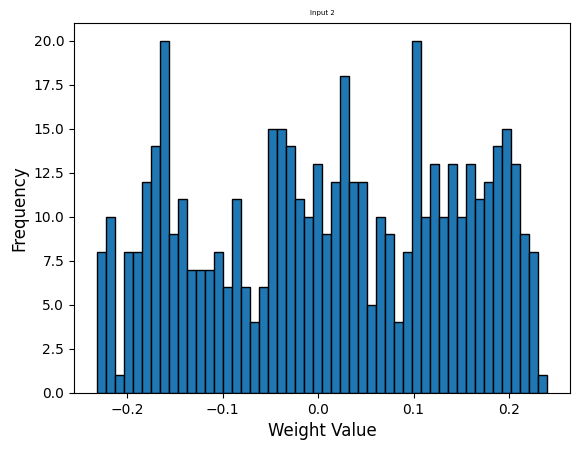

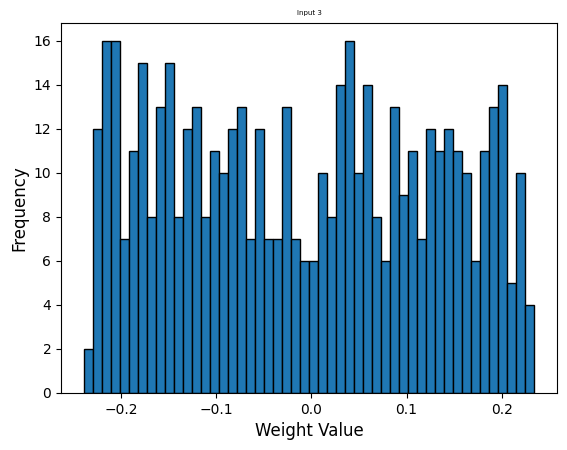

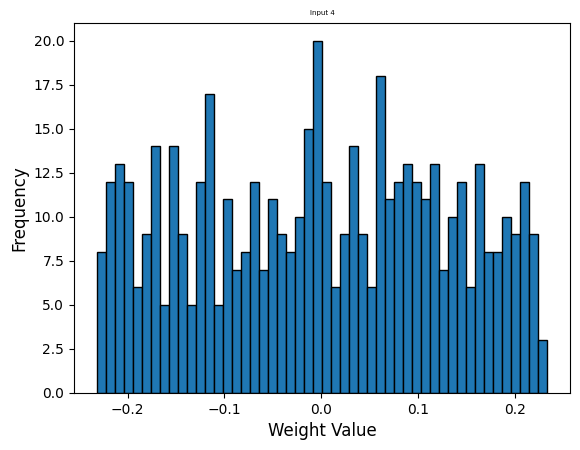

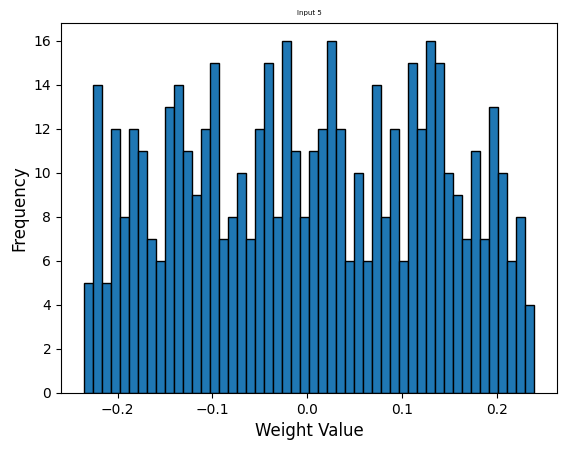

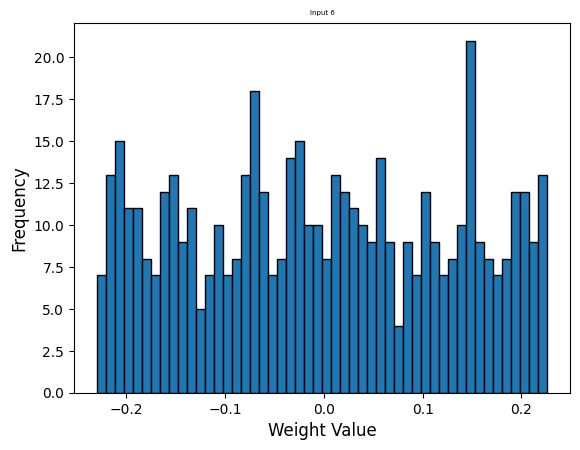

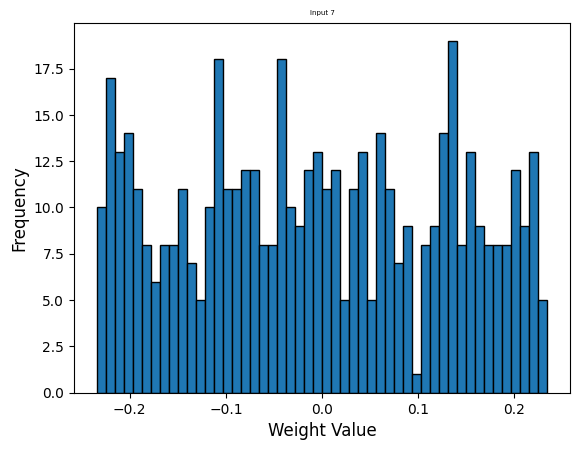

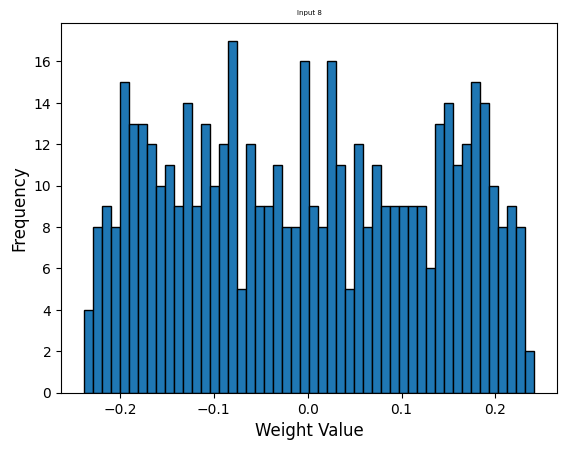

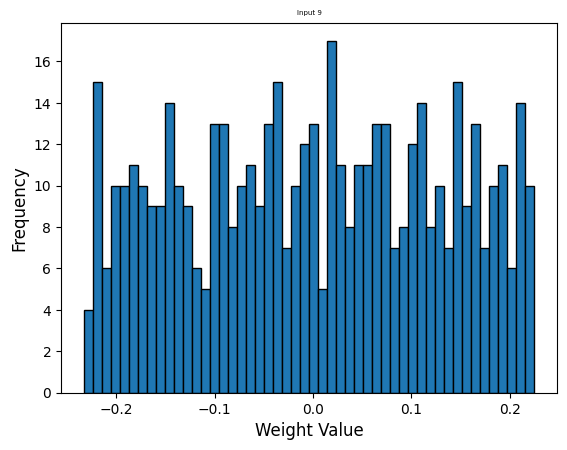

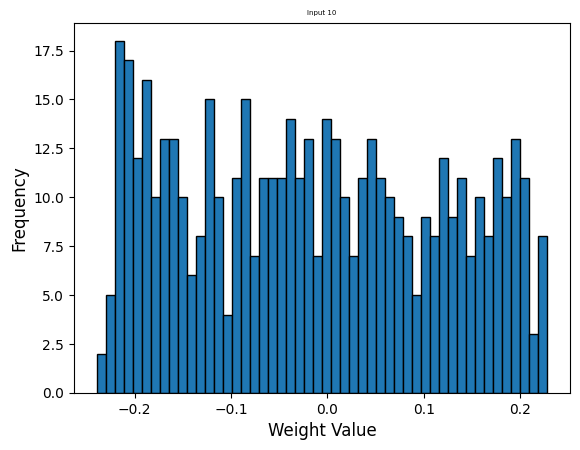

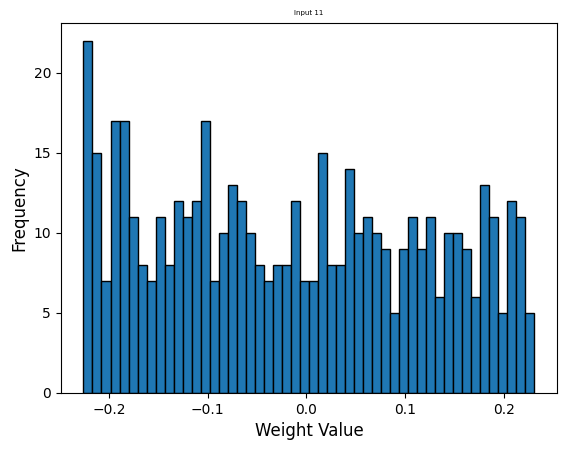

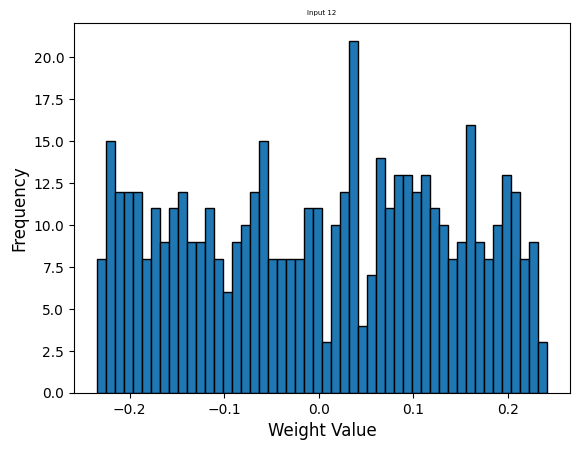

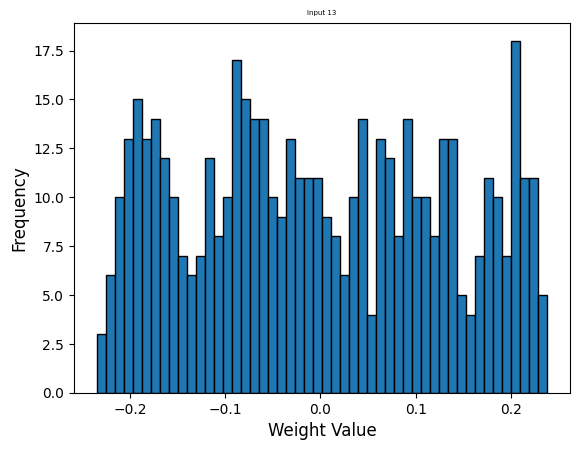

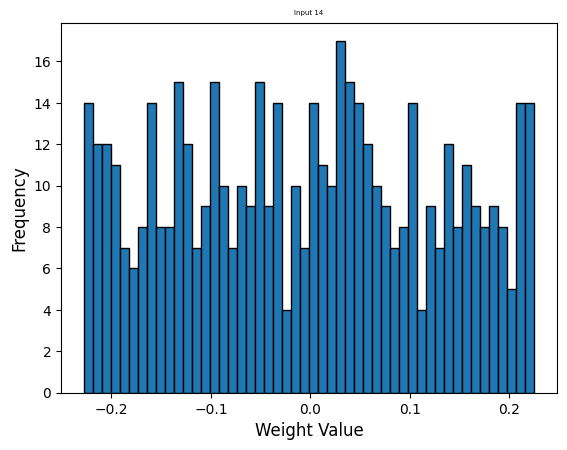

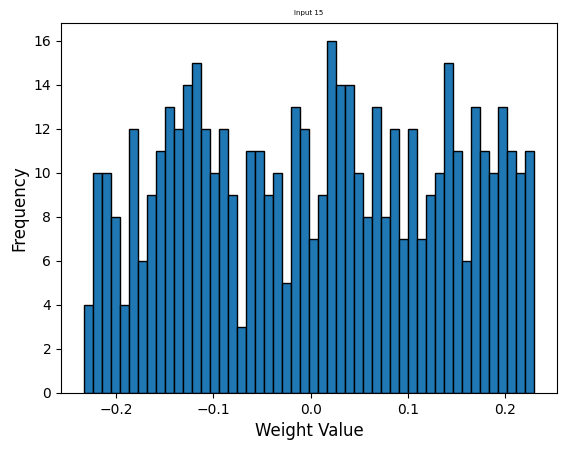

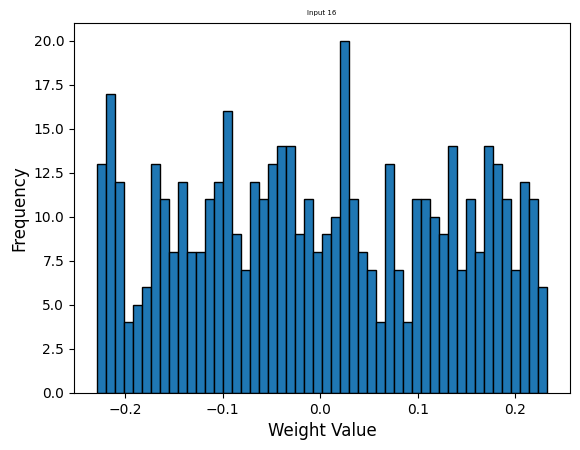

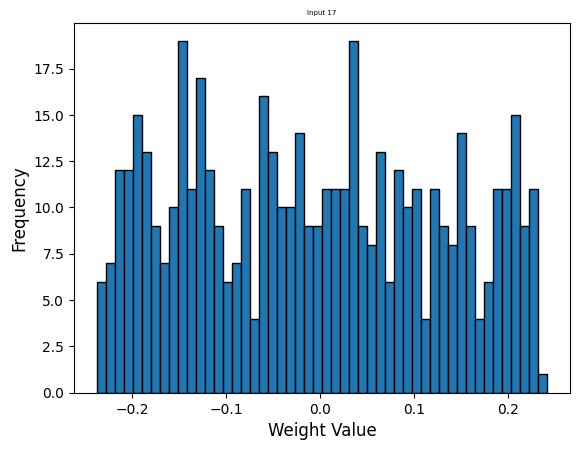

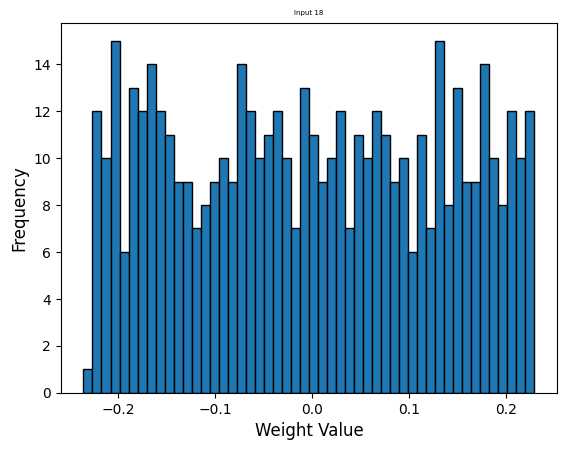

In [86]:
for i in np.arange(0,19):
    input_weights = first_layer[:,i].detach().numpy()
    counts, bin_edges, patches = plt.hist(input_weights, bins=50, edgecolor='black')
    #plt.xlim(-0.08,0.08)
    plt.title(f"Input {i}", fontsize=5)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel('Weight Value', fontsize=12)
    plt.savefig(f'figures/input{i}_hist.png', dpi=500)
    plt.show()

Parameter containing:
tensor([[-0.1998, -0.2099,  0.0237,  ..., -0.2292, -0.1479, -0.2254],
        [ 0.1751,  0.0759,  0.1594,  ..., -0.0493,  0.1912, -0.2139],
        [-0.1320,  0.0682,  0.0722,  ..., -0.1092,  0.1861,  0.1180],
        ...,
        [ 0.1810,  0.0579,  0.1933,  ..., -0.1710,  0.1190, -0.1474],
        [ 0.1960,  0.1386, -0.0272,  ..., -0.1688,  0.2149,  0.0080],
        [-0.2156,  0.0187, -0.0898,  ...,  0.1506,  0.0837,  0.1684]],
       requires_grad=True)


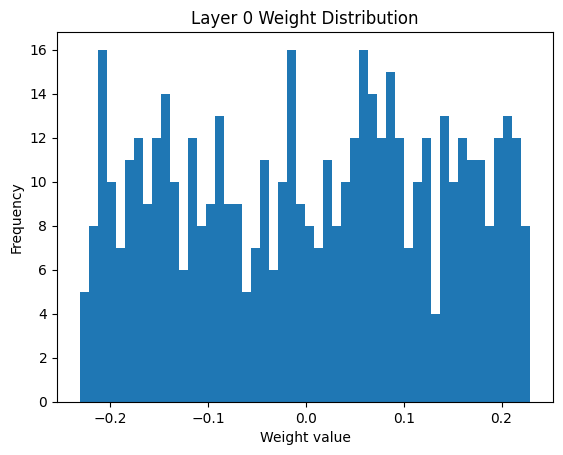

Parameter containing:
tensor([[ 0.0095, -0.0021, -0.0090,  ..., -0.0108,  0.0208, -0.0071],
        [ 0.0529, -0.0110, -0.0230,  ...,  0.0143,  0.0356, -0.0331],
        [ 0.0086,  0.0208, -0.0379,  ...,  0.0449,  0.0308, -0.0346],
        ...,
        [ 0.0108,  0.0236, -0.0396,  ...,  0.0111,  0.0035,  0.0165],
        [ 0.0322,  0.0271,  0.0413,  ..., -0.0248, -0.0443,  0.0183],
        [ 0.0413, -0.0527,  0.0214,  ...,  0.0343,  0.0191, -0.0259]],
       requires_grad=True)


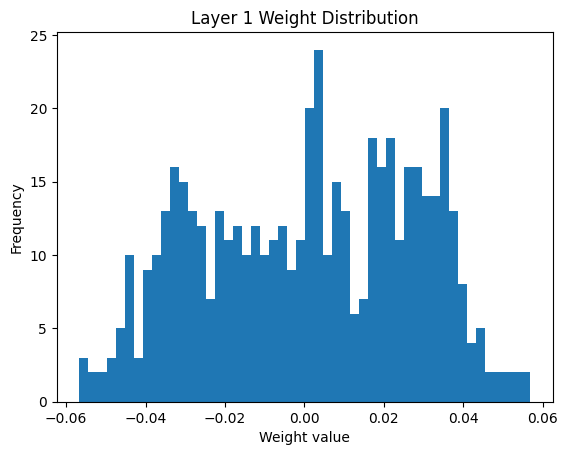

Parameter containing:
tensor([[-0.0201,  0.0015, -0.0257,  ..., -0.0374,  0.0120, -0.0564],
        [ 0.0444, -0.0202,  0.0095,  ...,  0.0013, -0.0424,  0.0315],
        [ 0.0221,  0.0049,  0.0051,  ..., -0.0337, -0.0313, -0.0303],
        ...,
        [-0.0340, -0.0273, -0.0303,  ..., -0.0153, -0.0075, -0.0173],
        [ 0.0386,  0.0133, -0.0362,  ..., -0.0085,  0.0336,  0.0190],
        [ 0.0222,  0.0344, -0.0050,  ..., -0.0293, -0.0290,  0.0237]],
       requires_grad=True)


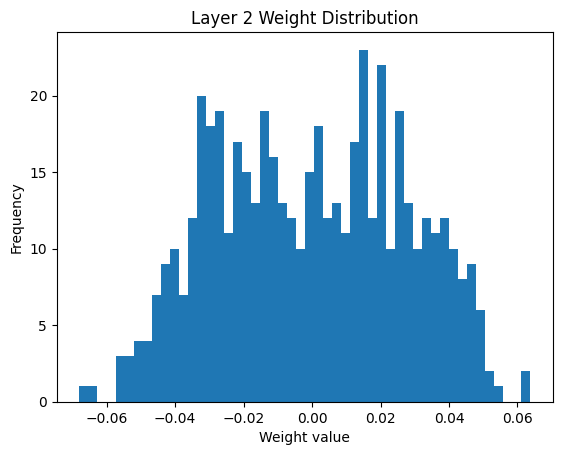

Parameter containing:
tensor([[ 0.0230,  0.0098, -0.0037,  ..., -0.0189,  0.0220,  0.0298],
        [-0.0205,  0.0151,  0.0135,  ..., -0.0023, -0.0247,  0.0207],
        [-0.0529,  0.0318, -0.0280,  ..., -0.0192, -0.0095,  0.0430],
        ...,
        [-0.0083,  0.0089, -0.0011,  ..., -0.0174,  0.0287,  0.0455],
        [-0.0324,  0.0187, -0.0482,  ...,  0.0335, -0.0414,  0.0353],
        [ 0.0118,  0.0036, -0.0371,  ..., -0.0020,  0.0294, -0.0075]],
       requires_grad=True)


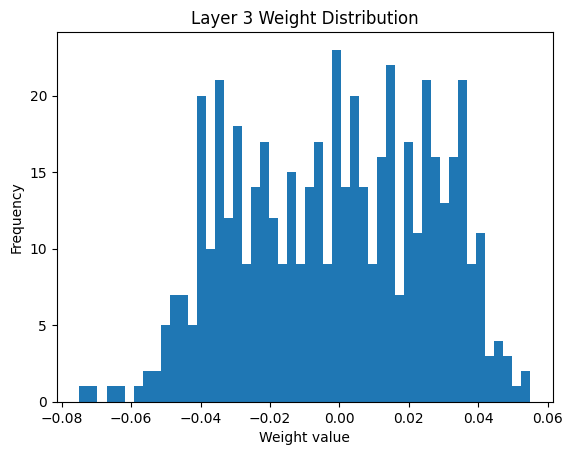

Parameter containing:
tensor([[ 0.0386, -0.0491, -0.0105,  ..., -0.0048,  0.0439,  0.0561],
        [ 0.0112,  0.0223, -0.0205,  ...,  0.0247,  0.0197,  0.0245],
        [ 0.0239, -0.0320, -0.0415,  ...,  0.0251, -0.0241, -0.0093]],
       requires_grad=True)


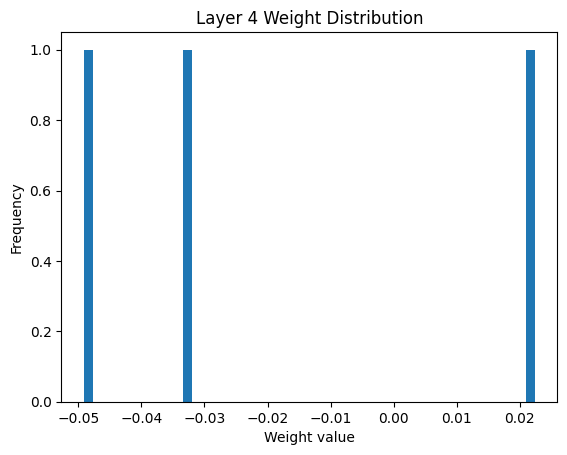

In [ ]:
# separate weights based on what is the input (interpretable)
# what about the nodes that have high frequency? 
# take top 10% of weights, and let me figure out which nodes had those weights 
# see the nodes with the highest weights corresponding to the input, and then see projection into the next layer
# 12 nodes with highest weight, node 37 had strongest possible input of input x, and then do the exactly the same thing
# --> going into direction of ellie pavlick , circuit analysis 
# follow the path of strongest weights
# 
# are the histograms between layers look similar? examine differences, bimodal, trimodal
# 
# break down into smaller info, histogram of one node, see if they look similar
# 
# go through the 19 nodes of input, see if they are similar
# if high odor node, is it also a high X nodes
# 
# look at pattern of weights coming into "turn left" node, see which nodes have the strongest role

for w_i, w_val in enumerate(weights):
    print(w_val)
    plt.hist(w_val.detach().numpy()[:,1], bins=50)
    plt.title(f"Layer {w_i} Weight Distribution")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.show()

## Hierarchical Clustering

Dendrograms show hierarchical relationships and similarities between neurons. The height of linkage between any two neurons shows their similarity. So, neurons that are closer together at the bottom are more similar. The accuracy of a dendrogram is best at the bottom.

The algorithm used below is agglomerative, meaning each data point is its own cluster at the start, and as you move up clusters become merged based on distance. The distance metric used is Euclidean (?), and the linkage method (distance between clusters) is Ward's method, which minimizes the variance within clusters.

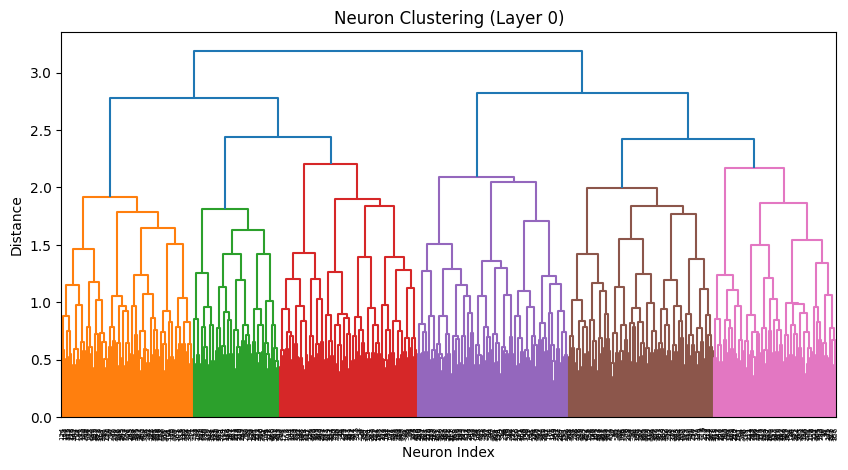

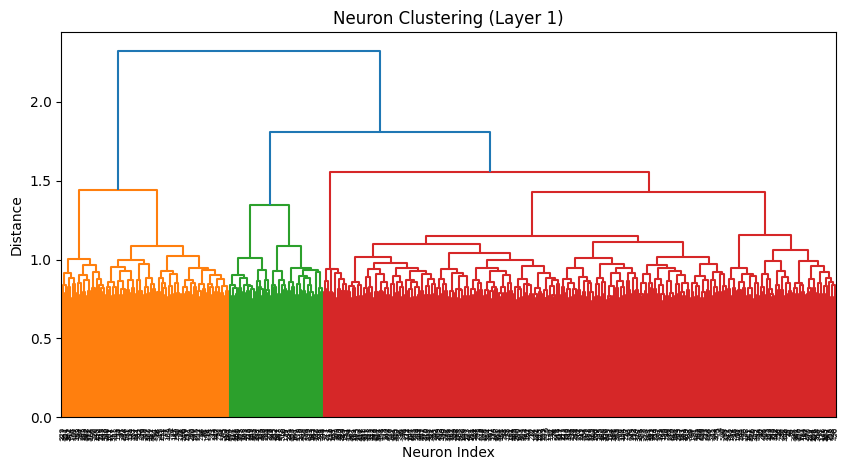

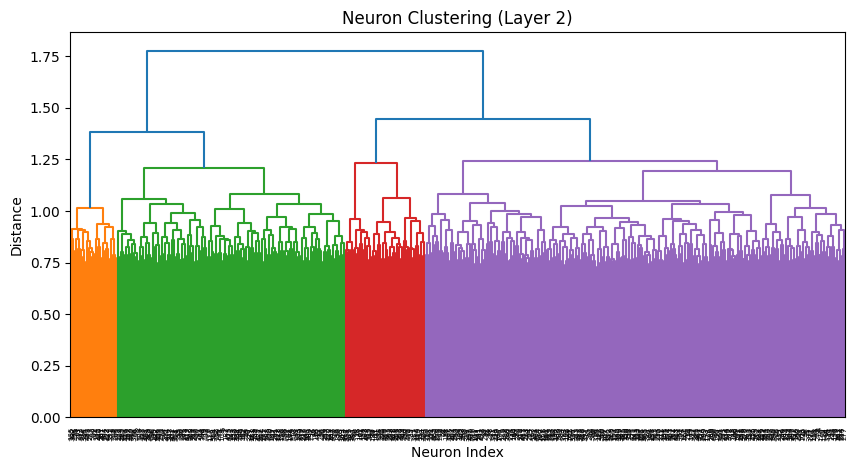

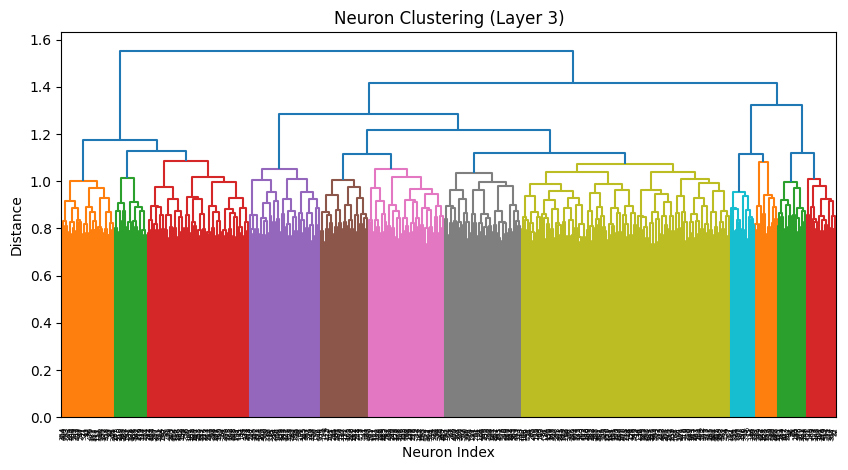

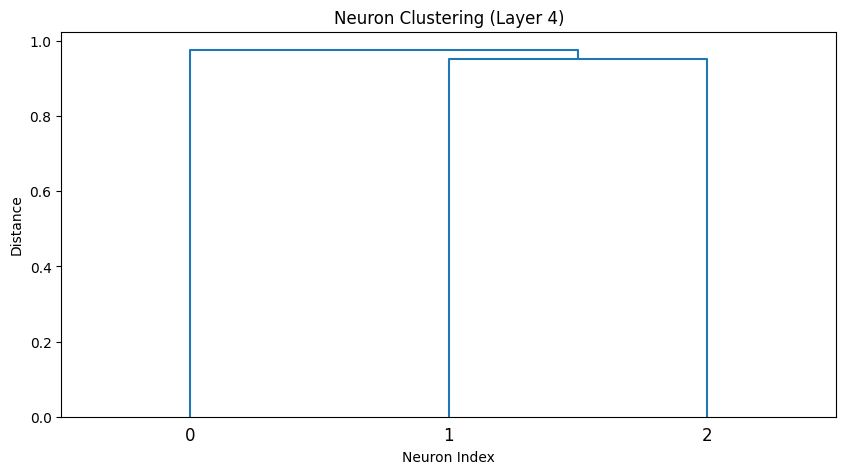

In [70]:
# higher distance -- more different clusters
# try synthetic data for intuition
# break down by cut points -- are some of the weights dependent on the odor vs. other sensory info?
# histogram of weight from odor node on left vs. right splits -- see if the two histograms separate
# for any one of the 512 node, take its x y weight and composite into a single number (norm), make histogram for left vs. right, and see if distinction
# looking for waht is leading to cut 

# meeting with ellie about interpretability 


## compare weight vs. activation

for w_i, w_val in enumerate(weights):
    W = w_val.detach().numpy()
    Z = linkage(W, method='ward')
    # Ward's Method computes clusters by comparing cluster pairs and choosing to merge based on the least increase in within cluser variance.
    # The distance on the y-axis is the increase in variance (?)

    plt.figure(figsize=(10, 5))
    dendrogram(Z) # colors are assigned based on the color threshold. all different clusters below the threshold are assigned different colors
                  # the threshold changes each layer because the default value is dependent on Z
    plt.title(f"Neuron Clustering (Layer {w_i})")
    plt.xlabel("Neuron Index")
    plt.ylabel("Distance")
    plt.show()

## t-SNE Clustering

t-SNE is a technique to create two-dimensional "maps" from very high-dimensional data. It takes a set of points in high-dimensional space (say, our model weights), and finds a faithful representation of those points in lower-dimensional space.

In [71]:
# Friday noon

# Sewell path analysis neural networks
# transformer attention, LLM/transformer circuit analysis 

# t-SNE Parameters
n_components = 2 # 2D projection
perplexity = [5, 20, 40] # exploring different values
max_iter = 5000
random_state = 0 # try multiple values to explore stability

KeyboardInterrupt: 

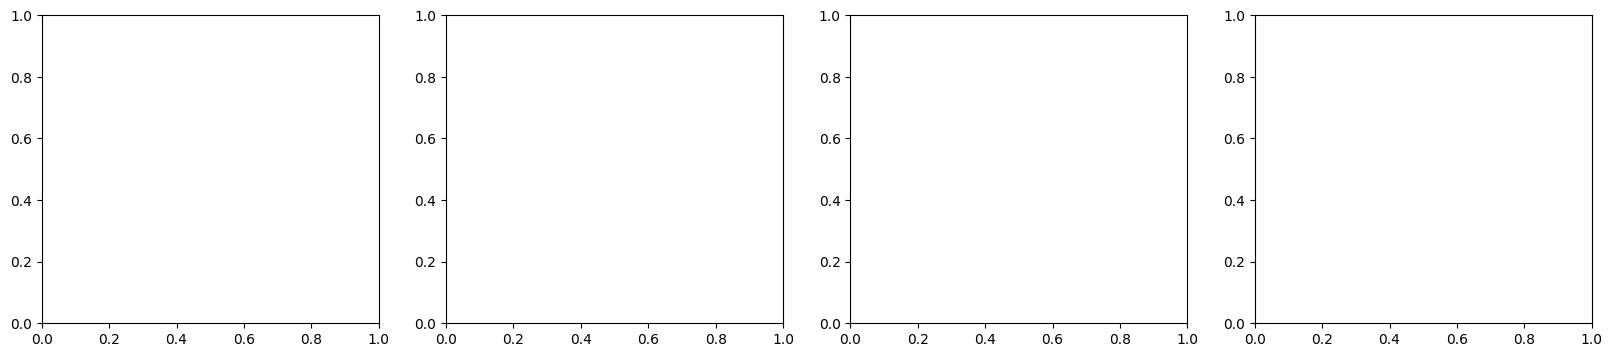

In [72]:
for p in perplexity:
    fig, ax = plt.subplots(1, len(weights) - 1, figsize=(20, 4))
    tsne = TSNE(n_components=n_components, perplexity=p, max_iter=max_iter, random_state=random_state, init='pca')
    for w_i, w_val in enumerate(weights[:-1]): # we don't take the output weights
        X = w_val.detach().numpy()
        Y = tsne.fit_transform(X)
        ax[w_i].scatter(Y[:, 0], Y[:, 1])
        ax[w_i].set_title(f"t-SNE with Perplexity = {p}, Layer = {w_i}")
        ax[w_i].xaxis.set_major_formatter(NullFormatter())
        ax[w_i].yaxis.set_major_formatter(NullFormatter())
        ax[w_i].set_xticks([])
        ax[w_i].set_yticks([])
        ax[w_i].axis("tight") 


## UMAP Clustering

/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


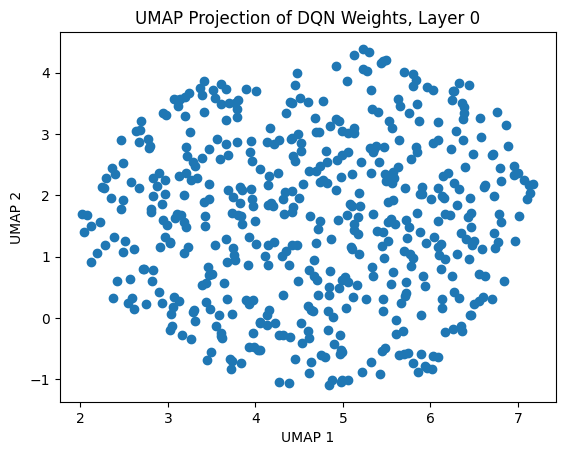

/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


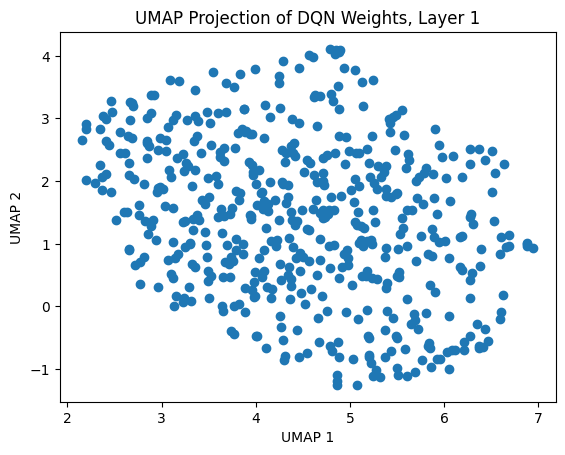

/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


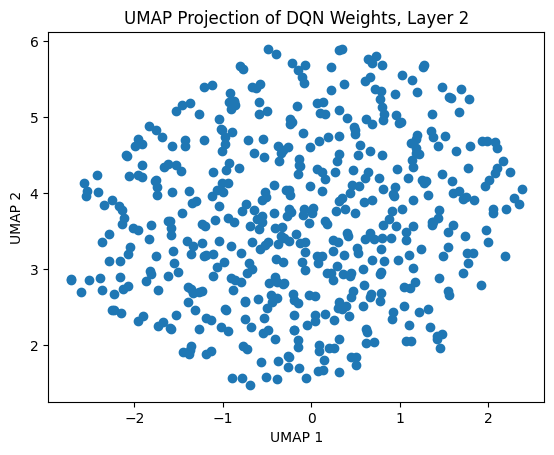

/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juanmendez/fleischmann-research/RL_Olfaction/cartesian_polar/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


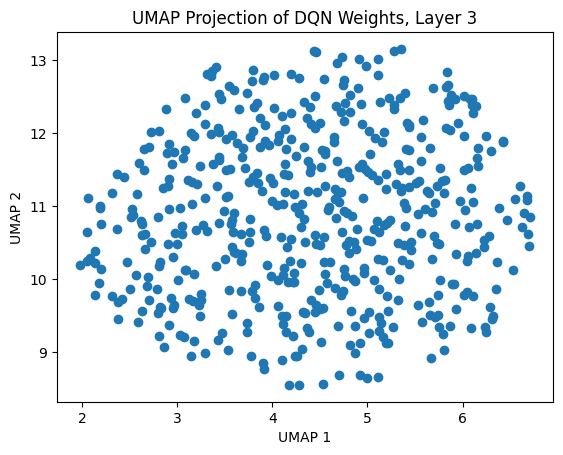

In [ ]:
for w_i, w_val in enumerate(weights[:-1]):
    scaled_weights = StandardScaler().fit_transform(w_val.detach().numpy()) # normalizing the data

    # applying UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(scaled_weights)

    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.title(f"UMAP Projection of DQN Weights, Layer {w_i}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

    # kmeans = KMeans(n_clusters=3)
    # labels = kmeans.fit_predict(embedding)

    # plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10')
    # plt.title("Clusters in DQN Weights via UMAP + KMeans")
    # plt.show

## Activation Analysis

In [ ]:
net = data_dict['net']
env = data_dict['env']

In [ ]:
input_cond, activations_layer_df = utils.get_activations_learned(
        net=net,
        env=env,
        layer_inspected=p.layer_inspected,
        contexts_labels=CONTEXTS_LABELS,
    )